# NPR MC2 Sentiment analysis 

Autoren:
- Michelle Rohrer
- Sabina Gruener

### Libraries  

Falls mit einer `venv` gearbeitet wird, muss die `venv` aktiviert sein. Dies kann über den Befehl `venv\\Scripts\\activate` ausgeführt werden.

In [1]:
import pkg_resources
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter  # um die Labels zu zählen
from transformers import AutoTokenizer, AutoModel
import torch

import seaborn as sns
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
import re
import langdetect
from langdetect import detect

from transformers import AutoTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pickle

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier
from transformers import pipeline
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

from sentence_transformers import SentenceTransformer

from src.plots import (
    baseline_evaluation_plot,
    evaluate_baseline_results,
    plot_tsne_for_all_embeddings,
    evaluate_weak_labels_quality,
    evaluate_and_plot_weak_labels,
    inspect_weak_label_distribution,
    plot_confusion_matrix_weak_labels,
    extract_metrics_per_split,
    plot_metrics_over_splits, 
    plot_confidence_distribution, 
    print_classification_report,
    plot_confusion_matrix,
    full_report_weighted
)

from src.utils import (
    save_explicit_imports_from_notebook,
    create_semi_supervised_splits_ratio_combined
)

from src.weak_label import (
    apply_centroid_weak_labelling_to_all_splits, 
    apply_zero_shot_to_all_splits,  
    apply_rf_balanced_to_all_splits,
    apply_heuristics_to_all_splits,
    apply_knn_weak_labelling_to_all_splits
)

from src.baseline import (
    train_with_pseudo_labels,
    pick_lr_params,
    get_embeddings,
    run_experiments_with_weights,
    split_nested_splits
)


C:\Users\Michelle\AppData\Local\Temp\ipykernel_14520\3522992856.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\Users\Michelle\Desktop\Uni\Challenge\npr_fs25\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Michelle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1]:
from src.utils import generate_toc

generate_toc('../MC2/main.ipynb')

#Inhaltsverzeichnis

- [NPR MC2 Sentiment analysis](#npr-mc2-sentiment-analysis)
    - [Libraries](#libraries)
  - [Kurzbeschreibung - Sentimentanalyse:](#kurzbeschreibung---sentimentanalyse)
    - [Sources](#sources)
  - [Explorative Datenanalyse & Datenvor- und Aufbereitung](#explorative-datenanalyse--datenvor--und-aufbereitung)
    - [Verteilung Contentlänge (inkl. Titel)](#verteilung-contentlänge-inkl-titel)
      - [Tokenlänge pro Text prüfen (für BERT/SBERT)](#tokenlänge-pro-text-prüfen-für-bertsbert)
    - [Hierachisch verschachtelte Trainingssplits](#hierachisch-verschachtelte-trainingssplits)
  - [Baseline-Modelle und Trainingsstrategien](#baseline-modelle-und-trainingsstrategien)
    - [1. Übersicht über die Modellierungsansätze](#1-übersicht-über-die-modellierungsansätze)
    - [2. Modellvarianten im Vergleich](#2-modellvarianten-im-vergleich)
      - [(a) Klassisches Baseline-Modell: TF-IDF + Logistic Regression](#a-klassisches-baseline-modell-tf-idf--logistic-regression)
      - [(b) Feature Extraction mit DistilBERT](#b-feature-extraction-mit-distilbert)
      - [(c) Fine-Tuning von DistilBERT](#c-fine-tuning-von-distilbert)
    - [3. Tokenisierung und Datenaufbereitung](#3-tokenisierung-und-datenaufbereitung)
    - [4. Hyperparameter und Ausführungsdetails](#4-hyperparameter-und-ausführungsdetails)
    - [5. Zielsetzung der Evaluation](#5-zielsetzung-der-evaluation)
    - [6. Bewertungsmetriken](#6-bewertungsmetriken)
    - [Evaluierung der Modelle](#evaluierung-der-modelle)
    - [Fazit: Vergleich der Modellierungsansätze](#fazit-vergleich-der-modellierungsansätze)
      - [Hauptbeobachtungen](#hauptbeobachtungen)
      - [Gesamtbewertung](#gesamtbewertung)
      - [Schlussfolgerung](#schlussfolgerung)
  - [Erstellung und Visualisierung semantischer Text-Embeddings mit `all-MiniLM-L6-v2`](#erstellung-und-visualisierung-semantischer-text-embeddings-mit-all-minilm-l6-v2)
    - [Zielsetzung](#zielsetzung)
    - [Verwendetes Modell: `all-MiniLM-L6-v2`](#verwendetes-modell-all-minilm-l6-v2)
      - [Modellspezifikationen](#modellspezifikationen)
    - [Visualisierung mit t-SNE](#visualisierung-mit-t-sne)
      - [Warum t-SNE?](#warum-t-sne)
- [Weak labels](#weak-labels)
    - [Generierung Weak labels](#generierung-weak-labels)
      - [**Centroid-Matching mit Sentence Embeddings**:](#centroid-matching-mit-sentence-embeddings)
      - [**Zero-Shot Classification mit NLI-Modellen (BART)**:](#zero-shot-classification-mit-nli-modellen-bart)
      - [**KNN mit SBERT-Embeddings (instanzbasierte Klassifikation)**:](#knn-mit-sbert-embeddings-instanzbasierte-klassifikation)
      - [**Random Forest Weak Labeling mit adaptivem Confidence-Threshold**](#random-forest-weak-labeling-mit-adaptivem-confidence-threshold)
      - [**Heuristik-basierte Weak Labeling Methode (mit gewichteter Mehrheitsabstimmung)**](#heuristik-basierte-weak-labeling-methode-mit-gewichteter-mehrheitsabstimmung)
  - [Centroid-Matching mit Sentence Embeddings](#centroid-matching-mit-sentence-embeddings)
  - [KNN mit SBERT](#knn-mit-sbert)
  - [Zero-Shot Classifier (BART, 0/1 Labels)](#zero-shot-classifier-bart-01-labels)
  - [Random Forest Classifier](#random-forest-classifier)
  - [Heuristic Labeling](#heuristic-labeling)
    - [Evaluierung Qualität Weak labels pre-training](#evaluierung-qualität-weak-labels-pre-training)
- [Modell-training mit Weak labels](#modell-training-mit-weak-labels)
    - [Erneutes Training mit Combination Hard & Weak labels in Trainingssplits](#erneutes-training-mit-combination-hard--weak-labels-in-trainingssplits)
      - [Auswahlbegründung:](#auswahlbegründung)
        - [Model:](#model)
        - [Centroid und Zero-Shot zur Weak-Label-Generierung:](#centroid-und-zero-shot-zur-weak-label-generierung)
        - [Metrikverläufe über Split-Größen hinweg](#metrikverläufe-über-split-größen-hinweg)
        - [Vergleich mit anderen Methoden](#vergleich-mit-anderen-methoden)
        - [Gesamtfazit](#gesamtfazit)
      - [**Analyse: Einfluss unterschiedlicher Weak-Label-Gewichtungen auf die Modellqualität (siehe Plots unten)**](#analyse-einfluss-unterschiedlicher-weak-label-gewichtungen-auf-die-modellqualität-siehe-plots-unten)
      - [**Auffälligkeit bei Split Size 0.6 – Analyse eines temporären Leistungsabfalls**](#auffälligkeit-bei-split-size-06--analyse-eines-temporären-leistungsabfalls)
      - [**Analyse: Mean Confidence vs. Split Size**](#analyse-mean-confidence-vs-split-size)
    - [Evaluierung (Weak & Hard Label) vs Baseline Leistung  (beides Feature-extraction-Ansatz)](#evaluierung-weak--hard-label-vs-baseline-leistung--beides-feature-extraction-ansatz)
    - [Vergleich: Feature Extraction mit Hard Labels vs. mit zusätzlich gewichteten Weak Labels](#vergleich-feature-extraction-mit-hard-labels-vs-mit-zusätzlich-gewichteten-weak-labels)
      - [Baseline (nur Hard Labels):](#baseline-nur-hard-labels)
      - [Feature Extraction mit Centroid (`weak_0.1`):](#feature-extraction-mit-centroid-weak_01)
      - [Feature Extraction mit Zero-Shot (`weak_0.1`):](#feature-extraction-mit-zero-shot-weak_01)
      - [Beobachtung bei starker Weak-Label-Gewichtung (`weak_1.0`):](#beobachtung-bei-starker-weak-label-gewichtung-weak_10)
    - [Interpretation:](#interpretation)
  - [Fazit](#fazit)
    - [Empfehlung zur Methodenauswahl](#empfehlung-zur-methodenauswahl)
    - [Gesamtausblick](#gesamtausblick)

In [ ]:
# Function um Requirements.txt upzudaten (bereits vorhandene Packages werden nicht erneut geladen - erste Versionsnummer bleibt)
#save_explicit_imports_from_notebook("main.ipynb")

Achtung: collections nicht im aktuellen Environment gefunden.
Achtung: json nicht im aktuellen Environment gefunden.
Achtung: os nicht im aktuellen Environment gefunden.
Achtung: pickle nicht im aktuellen Environment gefunden.
Achtung: pkg_resources nicht im aktuellen Environment gefunden.
Achtung: re nicht im aktuellen Environment gefunden.
Achtung: sentence_transformers nicht im aktuellen Environment gefunden.
Achtung: sklearn nicht im aktuellen Environment gefunden.
Achtung: src nicht im aktuellen Environment gefunden.
11 neue Pakete hinzugefügt.


## Kurzbeschreibung - Sentimentanalyse:

Ziel des Projekts ist die Untersuchung, wie weak labels den Bedarf an manuellen Sentiment-Labels reduzieren können. Dafür wurden drei Modellansätze getestet: eine klassische Baseline mit TF-IDF und logistischer Regression, ein Fine-Tuning eines vortrainierten Modells sowie ein Feature-Extraction-Modell mit Sentence-Embeddings.
Zur schwachen Labelgenerierung wurden verschiedene Verfahren eingesetzt: Centroid, KNN, Zero-Shot, heuristische Regeln und Random Forest. Die Modelle wurden mit unterschiedlich großen Datensätzen verglichen, um den Einfluss der weak labels auf die Modellleistung zu analysieren.
 

### Sources

**GitHub Repository Structure (Best Practices)**

- [GitHub Repository Structure Best Practices | by Soulaiman Ghanem | Code Factory Berlin | Medium](https://medium.com/code-factory-berlin/github-repository-structure-best-practices-284f1d93b75a)

**Notebooks ohne Output pushen (Vermeidung von Merge-Konflikten)**

- [Jupyter Notebook: Remove output before git push (Gist)](https://gist.github.com/33eyes/431e3d432f73371509d176d0dfb95b6e)

**Jupyter Book erstellen (HTML oder PDF)**

- [Jupyter Book - Getting Started](https://jupyterbook.org/en/stable/start/build.html)

**SBERT**
- https://www.sbert.net/

**Evaluierungsmetriken**

- https://www.getfocal.co/post/top-7-metrics-to-evaluate-sentiment-analysis-models 

**Weak Labeling**
- https://datasciencemilan.medium.com/weakly-supervised-learning-introduction-and-best-practices-c65f490d4a0a


## Explorative Datenanalyse & Datenvor- und Aufbereitung

In [3]:
ds = load_dataset("fancyzhx/amazon_polarity")

In [4]:
ds.items()

dict_items([('train', Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})), ('test', Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 400000
}))])

Das Datenset besteht aus insgesamt 4 Millionen Datenpunkten.  
Dieses ist in 3.600.000 Traindata und 400.000 Testdata Punkte unterteilt, wobei beide davon binär gelabeld sind [0 = negativ, 1 = positiv]. 

In [5]:
df_train = pd.DataFrame(ds["train"])
df_train.head(2)

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...


In [6]:
df_test = pd.DataFrame(ds["test"])
df_test.head(2)

,label,title,content
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...


**Columns:**
- "label": Je nach Rating -> 0 = negativ, 1 = positiv
- "title": Kurzer Titel oder Überschrift der Bewertung. Diese gibt oft in komprimierter Form die Stimmung des Nutzers wieder und enthält Schlagworte, die für die Sentiment-Analyse besonders informativ sein können.
- "content": Vollständiger Text der Bewertung. Dieser enthält typischerweise detaillierte Argumente, Meinungen oder Beschreibungen, auf deren Basis die Sentiment-Analyse durchgeführt wird.

**Fehlende Werte, Nullen?**

In [7]:
# Prozentsatz an fehlenden Werten pro Spalte
missing_percent_train = df_test.isna().mean() * 100
missing_percent_test= df_test.isna().mean() * 100
print("missing_percent Train & Test: \n")
print(missing_percent_train.round(2).sort_values(ascending=False))
print(missing_percent_test.round(2).sort_values(ascending=False))

missing_percent Train & Test: 

label      0.0
title      0.0
content    0.0
dtype: float64
label      0.0
title      0.0
content    0.0
dtype: float64


**Ausbalancierte Label?**

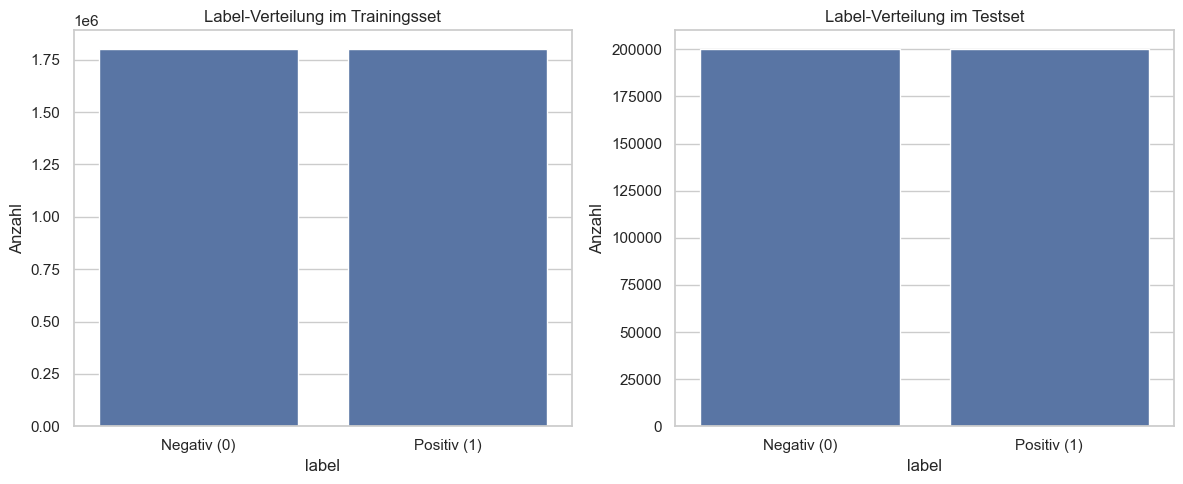

In [8]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Trainingsdaten: Labelverteilung
sns.countplot(data=df_train, x='label', ax=axes[0])
axes[0].set_title('Label-Verteilung im Trainingsset')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negativ (0)', 'Positiv (1)'])
axes[0].set_ylabel('Anzahl')

# Testdaten: Labelverteilung
sns.countplot(data=df_test, x='label', ax=axes[1])
axes[1].set_title('Label-Verteilung im Testset')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negativ (0)', 'Positiv (1)'])
axes[1].set_ylabel('Anzahl')

plt.tight_layout()
plt.show()

Die Label scheinen ausgeglichen und es gibt kein Klassenungleichgewicht, auf Methoden wie Stratified Sampling oder Class Weights kann daher verzichtet werden.   
Stratified Sampling wird nachfolgenden beim Reduzieren sowie beim Splitten des Trainingsdatensatzes verwendet um ausbalancierte Label auch weiterhin sicherzustellen.

Da eine Sentimentanalyse mit 4 Millionen Datenpunkten etwas über das Ziel eines Studentenprojekts hinausschiesst wird es vorerst auf etwa 10.000 reduziert, wobei nachfolgende Punkte beachtet und ausgeführt werden:

- Reduziert das Gesamtdataset auf ca. 10.000 Einträge
- Erhält das von Beginn an vorhandene Verhältnis 90 % Training / 10 % Test
- Erhält das Label-Verhältnis [0/1] ausgewogen
- Verwendet zufälliges Sampling ohne Duplikate
- Verwendet einen festen Seed für Reproduzierbarkeit


In [9]:
# Seed für Reproduzierbarkeit
SEED = 42

# Ziel: Gesamtanzahl reduzieren auf ca. 10.000
TARGET_TOTAL = 10000
TARGET_TEST_SIZE = 0.10  # 10% Test

# Kombinier zunächst Trainings- und Testdaten
df_all = pd.concat([df_train, df_test], ignore_index=True)

original_count = len(df_all)
# Entferne Duplikate basierend auf 'title' + 'content'
df_all['combined'] = df_all['title'].astype(str) + " " + df_all['content'].astype(str)
df_all = df_all.drop_duplicates(subset='combined')
df_all = df_all.drop(columns='combined')

deduplicated_count = len(df_all)
removed_duplicates = original_count - deduplicated_count
print(f"Entfernte Duplikate: {removed_duplicates}")

# Stratified Sampling, um Label-Verhältnis zu erhalten
df_reduced, _ = train_test_split(
    df_all,
    train_size=TARGET_TOTAL,
    stratify=df_all['label'],
    random_state=SEED
)

# Splitte in 90% Train, 10% Test, wieder stratified
df_train_small, df_test_small = train_test_split(
    df_reduced,
    test_size=TARGET_TEST_SIZE,
    stratify=df_reduced['label'],
    random_state=SEED
)

# Index zurücksetzen
df_train_small = df_train_small.reset_index(drop=True)
df_test_small = df_test_small.reset_index(drop=True)


Entfernte Duplikate: 0


**Prüfen ob Balance Label auch nach der Reduzierung des Samples verweiterhin vorhanden**

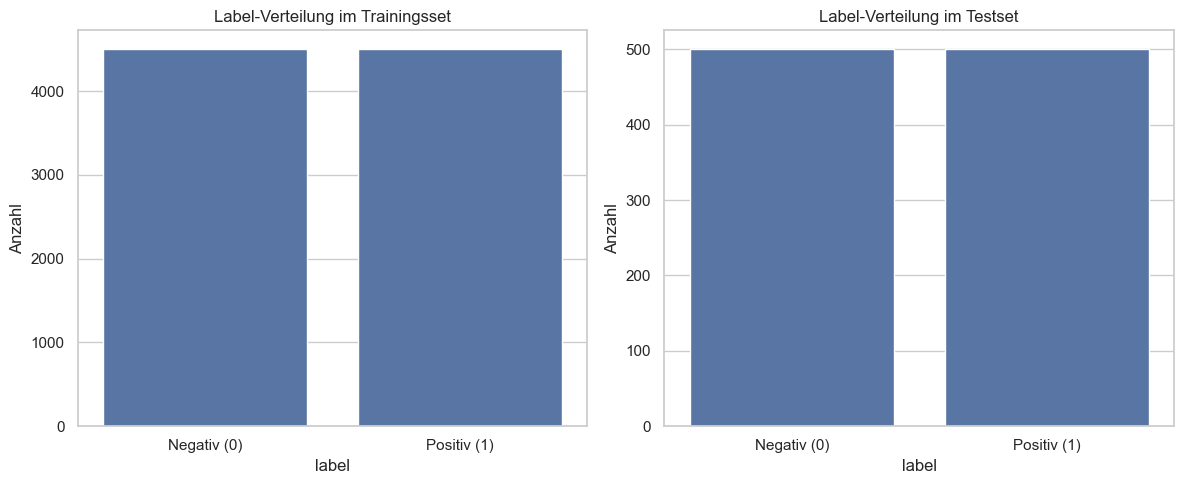

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Trainingsdaten: Labelverteilung
sns.countplot(data=df_train_small, x='label', ax=axes[0])
axes[0].set_title('Label-Verteilung im Trainingsset')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negativ (0)', 'Positiv (1)'])
axes[0].set_ylabel('Anzahl')

# Testdaten: Labelverteilung
sns.countplot(data=df_test_small, x='label', ax=axes[1])
axes[1].set_title('Label-Verteilung im Testset')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negativ (0)', 'Positiv (1)'])
axes[1].set_ylabel('Anzahl')

plt.tight_layout()
plt.show()

In [11]:
print("Shape df_train_small:", df_train_small.shape) 
print("Shape df_test_small:", df_test_small.shape)

Shape df_train_small: (9000, 3)
Shape df_test_small: (1000, 3)


**Basic Cleaning**    
Für dieses Projekt wurde bewusst ein einfaches "Basic Cleaning" angewendet, das lediglich Leerzeichen entfernt und fehlende Werte ersetzt. Da moderne Sprachmodelle wie BERT oder SBERT mit rohem, unbereinigtem Text umgehen können und intern bereits Tokenisierung und Normalisierung durchführen, ist aufwändiges Preprocessing (wie Stemming, Lemmatization oder das Entfernen von Satzzeichen) nicht notwendig. Das gewählte minimale Cleaning reicht daher aus, um die Daten konsistent und modellkompatibel vorzubereiten, ohne potenziell nützliche Information zu verlieren.

In [12]:
def basic_clean(text):
    if pd.isnull(text):
        return ""
    return str(text).strip()

# Anwenden auf title und content
df_train_small['title'] = df_train_small['title'].apply(basic_clean)
df_train_small['content'] = df_train_small['content'].apply(basic_clean)
df_test_small['title'] = df_test_small['title'].apply(basic_clean)
df_test_small['content'] = df_test_small['content'].apply(basic_clean)

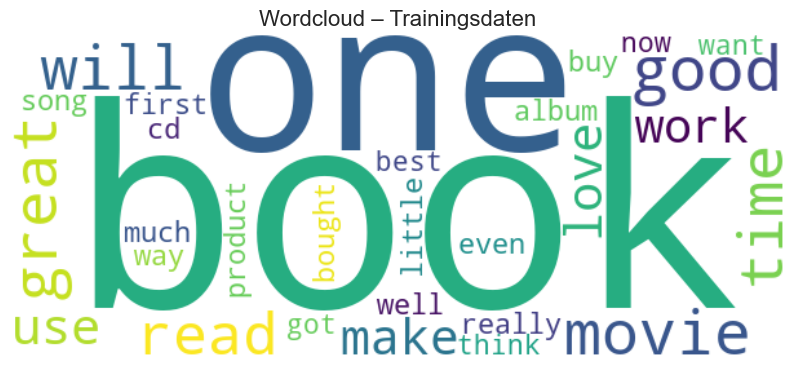

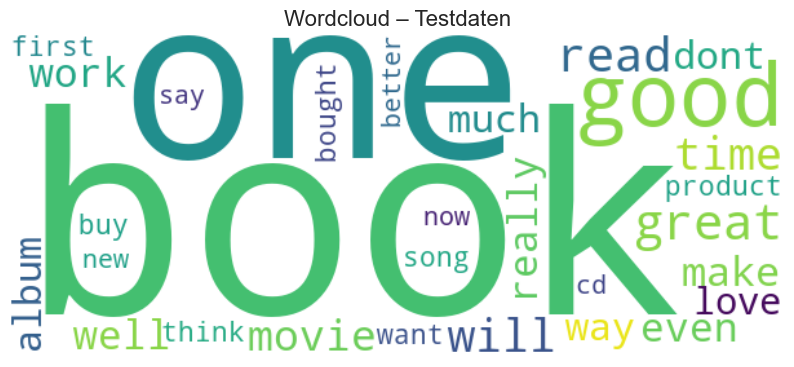

In [13]:
def preprocess_text(text):
    """Einfache Textvorverarbeitung: Kleinbuchstaben, nur Wörter"""
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', '', text)  # nur Buchstaben und Leerzeichen
    return text

def generate_wordcloud(df, column, title):
    """Wordcloud aus einem Text-DataFrame-Spalte erzeugen"""
    text = ' '.join(preprocess_text(t) for t in df[column])
    wordcloud = WordCloud(width=600, height=250, background_color='white', max_words=30).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


generate_wordcloud(df_train_small, 'content', 'Wordcloud – Trainingsdaten')
generate_wordcloud(df_test_small, 'content', 'Wordcloud – Testdaten')

Die Wordclouds der Trainings- und Testdaten zeigen eine hohe Übereinstimmung der häufigsten Begriffe, was auf eine inhaltlich vergleichbare Verteilung der Texte hinweist. Zentrale Wörter wie "book", "one", "great", "good", "movie" und "time" treten in beiden Sets prominent auf. Auch thematisch verwandte Begriffe wie "read", "album", "product" oder "bought" finden sich in beiden Visualisierungen.

Dies bestätigt, dass Train- und Testdaten ähnliche thematische Schwerpunkte aufweisen, was eine gute Grundlage für verlässliche Modellbewertung bietet. Starke Unterschiede in der Wortverteilung sind nicht erkennbar, sodass keine Verzerrung durch ungleich verteilte Inhalte zu erwarten ist.

**Content und title** korrekt oder eventuell vertauscht?  
Prüfen über Zeichenlänge

In [14]:
# Zeichenlänge
df_train_small['title_len'] = df_train_small['title'].astype(str).apply(len)
df_train_small['content_len'] = df_train_small['content'].astype(str).apply(len)

# Zeilen identifizieren, bei denen der Title länger oder gleich lang ist wie der Content
invalid_rows = df_train_small[df_train_small['content_len'] <= df_train_small['title_len']]
print(f"Anzahl eventuell problematischer Zeilen: {len(invalid_rows)}")

Anzahl eventuell problematischer Zeilen: 5


In [15]:
with pd.option_context('display.max_colwidth', None):
    print("Samples mit vertauschtem oder invalidem Content/Title:\n", invalid_rows.head(2))

Samples mit vertauschtem oder invalidem Content/Title:
      label  \
374      1   
721      1   

                                                                                         title  \
374  Review of Sudoku: More than 200 Fun and Challenging Japanese Number Puzzles by Tammy Seto   
721            Mens Premier Leather Single Layer Rainbow Sandals, Large 9.5-10.5, Sierra Brown   

                                                                            content  \
374  I am currently completing the puzzles in this book and so far, am enjoying it.   
721                                            Excellent service and FAST SHIPMENT!   

     title_len  content_len  
374         89           78  
721         79           36  


Einige Samples enthalten längere Titel als Content. Diese wurden beibehalten, da der Titel meist nur das Produkt beschreibt und in Modellen wie BERT/SBERT kontextuell gering gewichtet wird. Durch die spätere konsistente Kombination von Titel und Content bleibt der relevante Sentimentanteil erhalten, daher werden keine Samples entfernt.

**Prüfen auf einheitliche Sprache**

In [16]:
def check_language(df: pd.DataFrame, column: str) -> bool:
    """
    Prüft, ob alle Texte in einer bestimmten Spalte auf Englisch sind.

    Args:
        df
        column: Name der Spalte mit Text.

    Returns:
        bool: True, wenn alle Inhalte in der Spalte Englisch sind, sonst False.
    """
    try:
        all_english = all(
            langdetect.detect(text) == "en"
            if isinstance(text, str) and text.strip() != "" else False
            for text in df[column]
        )
    
        if all_english:
            print("Alle Inhalte sind auf Englisch.")
        else:
            print("Die Sprache ist nicht einheitlich Englisch.")
    
    except Exception as e:
        print(f"Fehler bei Spracherkennung: {e}")
        return False
    

check_language(df_train_small, "content")
check_language(df_test_small, "content")

Die Sprache ist nicht einheitlich Englisch.
Die Sprache ist nicht einheitlich Englisch.


In [ ]:
# Sprache für jede Zeile erkennen
def detect_language(text: str) -> str:
    try:
        return detect(text) if isinstance(text, str) and text.strip() != "" else "unknown"
    except:
        return "error"

# Neue Spalte Spracherkennung
df_train_small["language"] = df_train_small["content"].apply(detect_language)
df_test_small["language"] = df_test_small["content"].apply(detect_language)

# Sprachen zählen
language_counts_train = Counter(df_train_small["language"])
print("Anzahl Artikel pro erkannter Sprache (train):")
print(language_counts_train)
language_counts_test = Counter(df_test_small["language"])
print("Anzahl Artikel pro erkannter Sprache (test):")
print(language_counts_test)

In [ ]:
# Beispielzeile mit Sprache "es" Spanisch anzeigen
sample_langu = df_train_small[df_train_small['language'] == 'es'].sample(1, random_state=42)
print(sample_langu[['title', 'content']].to_string(index=False))

  title                                                                                                                                    content
Genial! Excelente calidad, Subtitulos en español (era lo unico que me preocupaba que tuviera). Muy buena cantidad de extras. Un muy buen producto!


In [ ]:
# Nur englische Einträge behalten (Sprache = 'en')
df_train_small = df_train_small[df_train_small['language'] == 'en'].reset_index(drop=True)
df_test_small = df_test_small[df_test_small['language'] == 'en'].reset_index(drop=True)

print(f"Train nach Filter: {len(df_train_small)} Zeilen")
print(f"Test nach Filter:  {len(df_test_small)} Zeilen")

Train nach Filter: 8969 Zeilen
Test nach Filter:  994 Zeilen


Es wurden einige Samples in einer anderen Sprache als Englisch erkannt. Für die Analyse wurden ausschließlich englischsprachige Texte berücksichtigt. Dies ist sinnvoll, da die eingesetzten Sprachmodelle (zB. BERT oder SBERT) auf englischsprachigen Daten vortrainiert wurden und bei anderen Sprachen deutlich an Genauigkeit verlieren können. Durch das Entfernen anderssprachiger Einträge wird eine konsistente Datenbasis gewährleistet, was die Modellleistung und Vergleichbarkeit der Ergebnisse verbessert. Da es sich nur um eine sehr geringe Anzahl im Verhältnis zur Gesamtdatenmenge (knapp 10.000 Samples) handelt, erfolgt kein Ersatz der entfernten Einträge durch zusätzliche englische Reviews.

**Titel dem Content hinzufügen**

In [ ]:
# Neue Spalte 'text' kombinieren Titel und Content
df_train_small['text'] = df_train_small['title'].astype(str).str.strip() + " : " + df_train_small['content'].astype(str).str.strip()
df_test_small['text'] = df_test_small['title'].astype(str).str.strip() + " : " + df_test_small['content'].astype(str).str.strip()

In [ ]:
df_train_small.head(2)

,label,title,content,title_len,content_len,language,text
0,1,"An Easy to Read, Moving Memoir",Red Azalea is a memoir of Anchee Min's life as...,30,790,en,"An Easy to Read, Moving Memoir : Red Azalea is..."
1,1,"A wonderful ""supernatural"" thriller","Just finished reading Mr Murder, the first (an...",35,664,en,"A wonderful ""supernatural"" thriller : Just fin..."


### Verteilung Contentlänge (inkl. Titel)

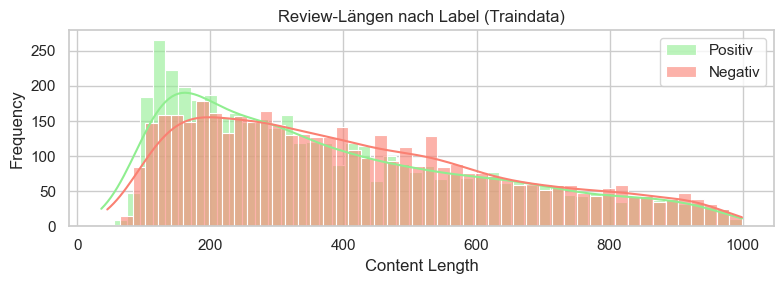

In [ ]:
plt.figure(figsize=(8, 3))

# Histogramm für positive Reviews
sns.histplot(
    df_train_small[df_train_small['label'] == 1]['content_len'],
    bins=50, kde=True, color='lightgreen', label='Positiv', alpha=0.6
)
# Histogramm für negative Reviews
sns.histplot(
    df_train_small[df_train_small['label'] == 0]['content_len'],
    bins=50, kde=True, color='salmon', label='Negativ', alpha=0.6
)

plt.title("Review-Längen nach Label (Traindata)")
plt.xlabel("Content Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

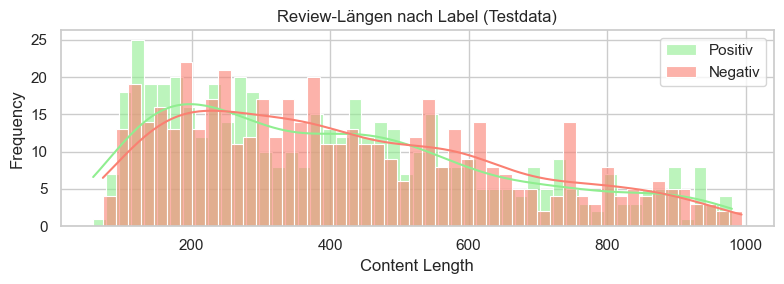

In [ ]:
df_test_small["content_len"] = df_test_small["content"].apply(len)
plt.figure(figsize=(8, 3))

# Histogramm für positive Reviews
sns.histplot(
    df_test_small[df_test_small['label'] == 1]['content_len'],
    bins=50, kde=True, color='lightgreen', label='Positiv', alpha=0.6
)
# Histogramm für negative Reviews
sns.histplot(
    df_test_small[df_test_small['label'] == 0]['content_len'],
    bins=50, kde=True, color='salmon', label='Negativ', alpha=0.6
)

plt.title("Review-Längen nach Label (Testdata)")
plt.xlabel("Content Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

* **Trainingsdaten:**  
Im Trainingsdatensatz fällt auf, dass positive Reviews tendenziell kürzer sind als negative. Besonders im Bereich zwischen 100 und 300 Zeichen treten positive Texte mit deutlich höherer Frequenz auf. Negative Reviews hingegen verteilen sich gleichmäßiger über ein breiteres Längenspektrum und sind insbesondere bei längeren Texten ab ca. 300 Zeichen häufiger vertreten. Dies deutet darauf hin, dass negative Reviews oft ausführlicher formuliert sind - möglicherweise, weil Nutzer mehr Details zu Kritikpunkten liefern.

* **Testdaten:**  
Im Testdatensatz zeigt sich ein ähnliches, wenn auch weniger ausgeprägtes Muster. Aufgrund der geringeren Anzahl an Beispielen sind die Verteilungen insgesamt unregelmäßiger, aber auch hier dominieren positive Reviews im kürzeren Längenbereich leicht. Die beiden Kurven verlaufen jedoch näher beieinander als im Trainingsset, was auf eine ausgewogenere Längenverteilung im Testdatensatz hinweist.

* **Fazit und Einordnung:**  
Insgesamt bestätigen die Verteilungen eine häufige Beobachtung im Bereich der Sentimentanalyse: positive Rückmeldungen sind oft kürzer und direkter, während negative Bewertungen länger und differenzierter ausfallen. Dieses Muster könnte beim Modelltraining theoretisch zu einer Verzerrung führen, wenn das Modell Textlänge implizit mit Sentiment assoziiert.

In der vorliegenden Analyse ist der **Unterschied jedoch nicht stark genug, um sofortige Maßnahmen zu erfordern.**   
Die Verteilungen überlappen weitgehend, und moderne Sprachmodelle wie BERT/SBERT sind in der Lage, den semantischen Kontext einzelner Tokens zu erfassen, ohne sich explizit an der Textlänge zu orientieren. Dennoch empfiehlt es sich, diesen Aspekt bei der Interpretation der Modellergebnisse im Hinterkopf zu behalten - insbesondere bei einer Analyse möglicher Fehlklassifikationen oder bei einer späteren Evaluation getrennt nach Textlängen.

#### Tokenlänge pro Text prüfen (für BERT/SBERT)

In [ ]:
# Lade BERT-Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Funktion Zählung Tokenanzahl
def get_token_length(text):
    return len(tokenizer.tokenize(str(text)))

# Anwenden auf Trainings- und Testdaten
df_train_small['token_len'] = df_train_small['text'].apply(get_token_length)
df_test_small['token_len'] = df_test_small['text'].apply(get_token_length)

# Zeilen über 512 Tokens anzeigen
too_long_train = df_train_small[df_train_small['token_len'] > 512]
too_long_test = df_test_small[df_test_small['token_len'] > 512]

# Out: längste Texte
print("Maximale Token-Länge (Train):", df_train_small['token_len'].max())
print("Maximale Token-Länge (Test):", df_test_small['token_len'].max())
print("Anzahl rows welche >= Maximale Token-Länge 512 (Train):", len(too_long_train))
print("Anzahl rows welche >= Maximale Token-Länge 512 (Test):", len(too_long_test))

Maximale Token-Länge (Train): 292
Maximale Token-Länge (Test): 267
Anzahl rows welche >= Maximale Token-Länge 512 (Train): 0
Anzahl rows welche >= Maximale Token-Länge 512 (Test): 0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Michelle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michelle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


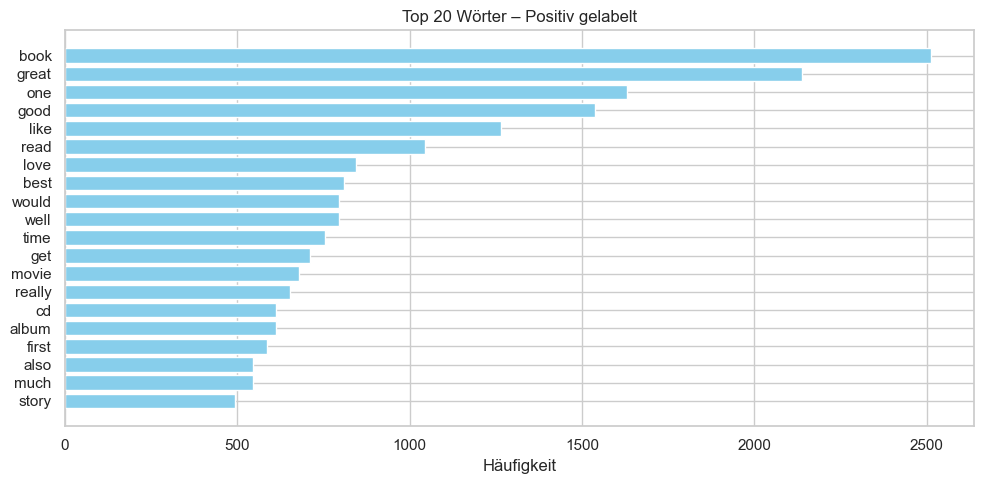

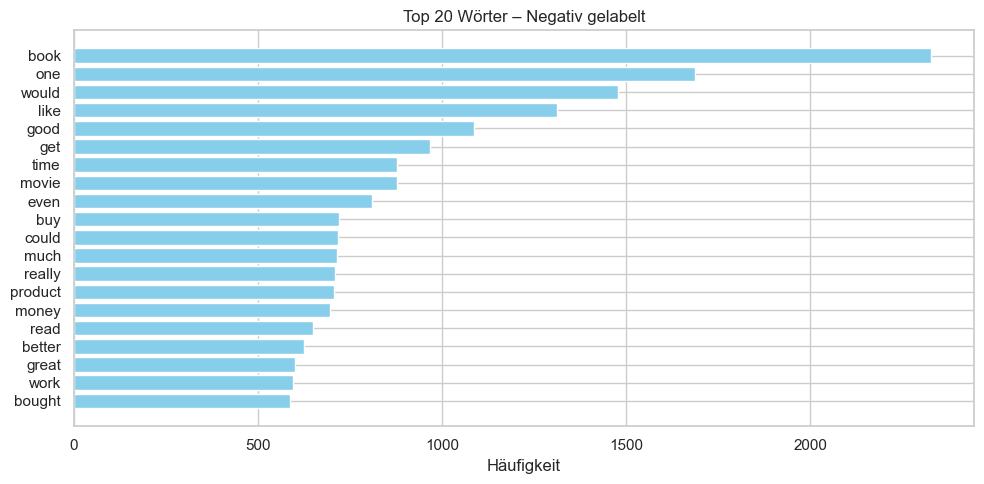

In [ ]:
# Nur beim 1. Mal nötig
nltk.download('punkt')
nltk.download('stopwords')
# Stoppwörter laden
stop_words = set(stopwords.words('english'))

# Tokenisierung & Filterung
def tokenize_and_filter(text):
    tokens = word_tokenize(str(text).lower())
    return [t for t in tokens if t.isalpha() and t not in stop_words]

# Token-Listen extrahieren
positive_words = df_train_small[df_train_small['label'] == 1]['text'].apply(tokenize_and_filter).sum()
negative_words = df_train_small[df_train_small['label'] == 0]['text'].apply(tokenize_and_filter).sum()

pos_counts = Counter(positive_words)
neg_counts = Counter(negative_words)

# Top-Wörter nach Label
top_pos = pos_counts.most_common(20)
top_neg = neg_counts.most_common(20)


# Vergleichstabelle mit Differenz
all_words = set(pos_counts) | set(neg_counts)
word_data = []
for word in all_words:
    pos = pos_counts.get(word, 0)
    neg = neg_counts.get(word, 0)
    total = pos + neg
    diff = pos - neg
    if total >= 100:
        word_data.append({'word': word, 'pos': pos, 'neg': neg, 'total': total, 'diff': diff})

df_words = pd.DataFrame(word_data).sort_values('total', ascending=False)

# Plot-Funktion für einzelne Klasse
def plot_top_words(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Häufigkeit")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_top_words(top_pos, "Top 20 Wörter – Positiv gelabelt")
plot_top_words(top_neg, "Top 20 Wörter – Negativ gelabelt")

**Die Visualisierungen zeigen die 20 häufigsten Wörter in positiv und negativ gelabelten Reviews.**  
In positiven Texten dominieren wertende Begriffe wie "great", "good", "love" und "best", während in negativen Reviews häufiger Wörter wie "money", "product", "bought" und "could" erscheinen - oft im Kontext von Kritik. **Einige Wörter wie "book", "one" oder "like" kommen in beiden Klassen vor und sind kontextabhängig.** Die Analyse verdeutlicht, dass einfache Häufigkeitsvergleiche erste Hinweise auf sprachliche Muster geben, aber kontextbasierte Modelle wie BERT nötig sind, um die Bedeutung im jeweiligen Zusammenhang korrekt zu erfassen.

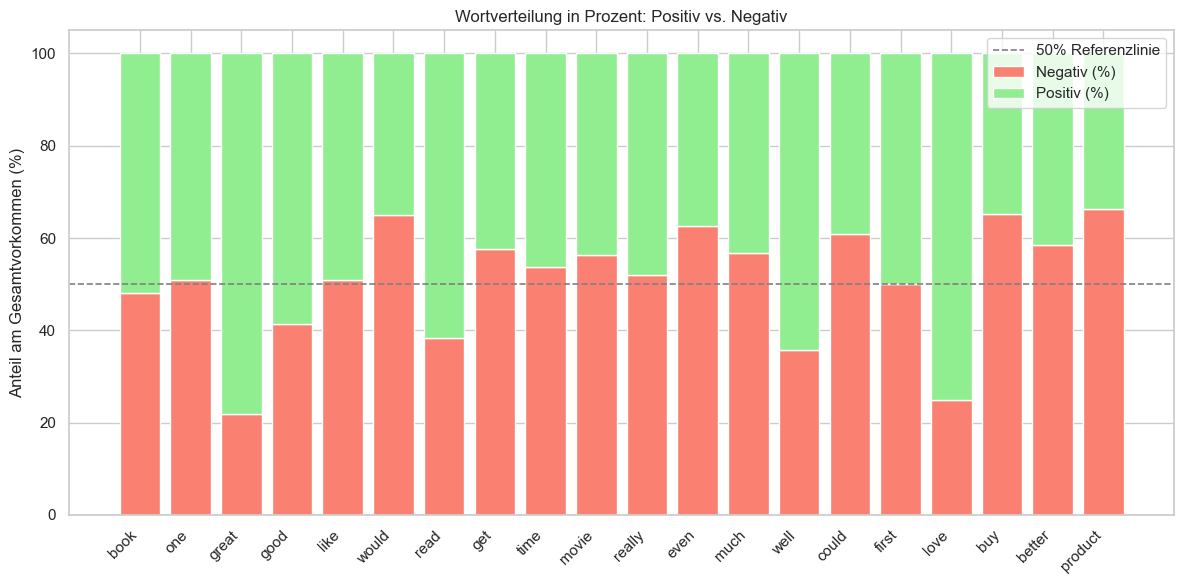

In [ ]:
# Prozentsatz berechnen
df_words['pos_pct'] = (df_words['pos'] / df_words['total']) * 100
df_words['neg_pct'] = (df_words['neg'] / df_words['total']) * 100

# Top 20 nach total
df_pct = df_words.sort_values('total', ascending=False).head(20)

x = np.arange(len(df_pct))
plt.figure(figsize=(12, 6))
plt.bar(x, df_pct['neg_pct'], label='Negativ (%)', color='salmon')
plt.bar(x, df_pct['pos_pct'], bottom=df_pct['neg_pct'], label='Positiv (%)', color='lightgreen')

# Mittellinie
plt.axhline(50, color='gray', linestyle='--', linewidth=1.2, label='50% Referenzlinie')

plt.xticks(ticks=x, labels=df_pct['word'], rotation=45, ha='right')
plt.ylabel("Anteil am Gesamtvorkommen (%)")
plt.title("Wortverteilung in Prozent: Positiv vs. Negativ")
plt.legend()
plt.tight_layout()
plt.show()

Die prozentuale Verteilung in dieser Grafik bestätigt nun diese Tendenzen: "great", "love" und "first" sind klar positiv dominiert, während "product", "better" und "buy" häufiger in negativen Texten vorkommen.
Besonders deutlich wird hier auch, dass Begriffe wie "book", "one" oder "like" nahezu ausgeglichen auftreten - was ihre bereits erwähnte kontextabhängige Bedeutung bestätigt.

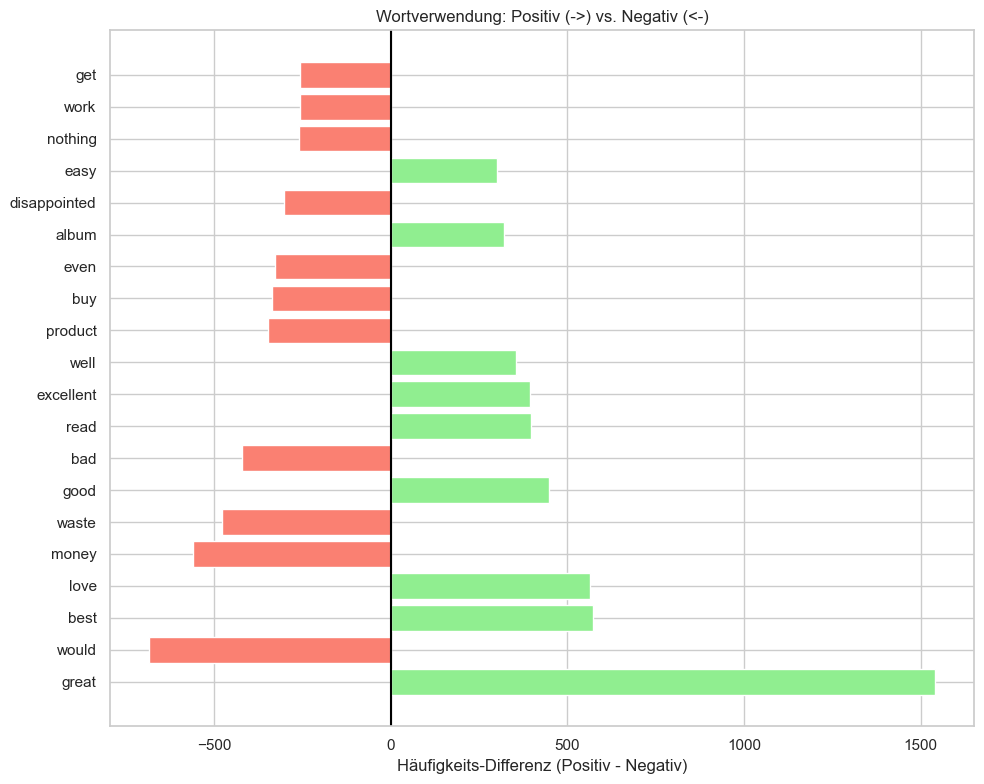

In [ ]:
# Alle Wörter (pos/neg) zusammenführen
all_words = set(pos_counts) | set(neg_counts)

# Differenzberechnung
data = []
for word in all_words:
    pos = pos_counts.get(word, 0)
    neg = neg_counts.get(word, 0)
    total = pos + neg
    if total >= 100:  # nur häufige Wörter anzeigen
        data.append({'word': word, 'pos': pos, 'neg': neg, 'diff': pos - neg})

# Df erstellen und sortieren
df_diff = pd.DataFrame(data)
df_diff = df_diff.sort_values('diff', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(df_diff['word'], df_diff['diff'], color=df_diff['diff'].apply(lambda x: 'lightgreen' if x > 0 else 'salmon'))
plt.axvline(0, color='black')
plt.title("Wortverwendung: Positiv (->) vs. Negativ (<-)")
plt.xlabel("Häufigkeits-Differenz (Positiv - Negativ)")
plt.tight_layout()
plt.show()

Diese Darstellung ergänzt die vorherigen Analysen, indem sie die absolute Differenz der Wortverwendung zwischen positiv und negativ gelabelten Reviews zeigt. **Wörter mit hoher Differenz liefern besonders starke Hinweise auf das jeweilige Sentiment.**  

Begriffe wie "great", "best", "love", "excellent" oder "good" treten deutlich häufiger in positiven Reviews auf (grüne Balken -> rechts), was bereits in den vorherigen Plots durch hohe absolute Häufigkeit und positive Prozentanteile sichtbar war.  

Umgekehrt zeigen Wörter wie "would", "money", "waste", "bad", "disappointed" und "product" eine deutlich höhere Verwendung in negativen Texten (rote Balken -> links), was die bereits beobachtete Assoziation mit kritischen Aussagen weiter stützt.  

Besonders hilfreich an dieser Darstellung ist, dass sie nun nicht nur Häufigkeit oder Verteilung prozentual zeigt, sondern den direkten **Polaritätsunterschied auf einen Blick** quantifiziert. Dadurch lassen sich Wörter klar identifizieren, die stark zur **Unterscheidung von Sentiment-Klassen** beitragen können - zB. für Keyword-basierte Features oder Interpretierbarkeit eines Modells.  

Die identifizierten stark polarisierenden Wörter können bei der späteren **Erstellung von Weak Labels unterstützend** eingesetzt werden. Sie eignen sich besonders gut als heuristische Merkmale, um unbeschriftete Texte grob einem Sentiment zuzuordnen - etwa durch einfache Regeln oder keywordbasierte Gewichtungen. Obwohl solche Ansätze nicht den Kontext erfassen wie transformerbasierte Modelle, liefern sie eine wertvolle Grundlage für erste automatische Labelvorschläge im Rahmen des Weak Labeling.

**Alle anderen Columns nun droppen** über bleibt **text (title + content), label**

In [ ]:
df_train_final = df_train_small[['text', 'label']].copy()
df_test_final = df_test_small[['text', 'label']].copy()

In [ ]:
with pd.option_context('display.max_colwidth', None):
    print("Sample Print Final df_train :\n", df_train_final.head(5))

Sample Print Final df_train :
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
0           

### Hierachisch verschachtelte Trainingssplits  

Zur Beurteilung des Einflusses der Trainingsdatensatzgröße auf die Modellleistung werden hier hierarchisch verschachtelte, stratifizierte Trainingssplits erstellt – jede Stufe enthält alle vorherigen Daten und ermöglicht so die systematische Analyse der Lernkurve.  

0.1 enthält die ersten 10 % des geshuffelten, stratifizierten DataFrames  
0.2 enthält die ersten 20 % -> die 10 % von vorher + 10 % neue  
0.4 enthält 40 % -> also alle aus 0.2 + weitere 20 %  

Split	Anzahl Samples  
10 %	1.000  -> später für weaklabel davon 500 unlabeln  
20 %	2.000  
40 %	4.000  
60 %	6.000  
80 %	8.000  
100 %	9.000+  

In [ ]:
def create_nested_train_splits_stratified(df, label_col='label', sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0], seed=42):
    """
    Erstellt hierarchisch geschachtelte Trainingssplits mit stratifiziertem Sampling.
    """
    # Dummy-Split mit sehr kleinem test_size, wir verwenden nur den Trainingsanteil (stratifiziert geshuffelt)
    df_shuffled, _ = train_test_split(
        df,
        test_size=0.001,  # Minimaler Testanteil, damit der Rest gemischt zurückkommt
        stratify=df[label_col],
        random_state=seed
    )
    df_shuffled = df_shuffled.reset_index(drop=True)

    nested_splits = {}
    for size in sizes:
        count = int(len(df_shuffled) * size)
        nested_splits[size] = df_shuffled.iloc[:count].copy()

    return nested_splits

In [ ]:
def plot_label_distribution_over_splits_stacked(nested_splits):
    data = []
    subset_labels = []

    for i, (size, df) in enumerate(nested_splits.items(), 1):
        counts = df['label'].value_counts().to_dict()
        total = len(df)
        subset_labels.append(f'Subset {i}')
        data.append([counts.get(0, 0), counts.get(1, 0)])

    data = np.array(data)
    label_0 = data[:, 0]
    label_1 = data[:, 1]
    total = label_0 + label_1

    x = np.arange(len(subset_labels))

    plt.figure(figsize=(10, 6))
    plt.bar(x, label_0, label='Label 0', color='skyblue')
    plt.bar(x, label_1, bottom=label_0, label='Label 1', color='lightgreen')

    # Wachstumslinie
    plt.plot(x, total, color='orange', marker='o', label='Wachstumslinie')

    plt.xticks(x, subset_labels, rotation=30)
    plt.xlabel('Subset Number')
    plt.ylabel('Anzahl Zeilen')
    plt.title('Datensatzwachstum nach Label (Stacked)')
    plt.legend(title='Datensatz und Label')
    plt.tight_layout()
    plt.show()


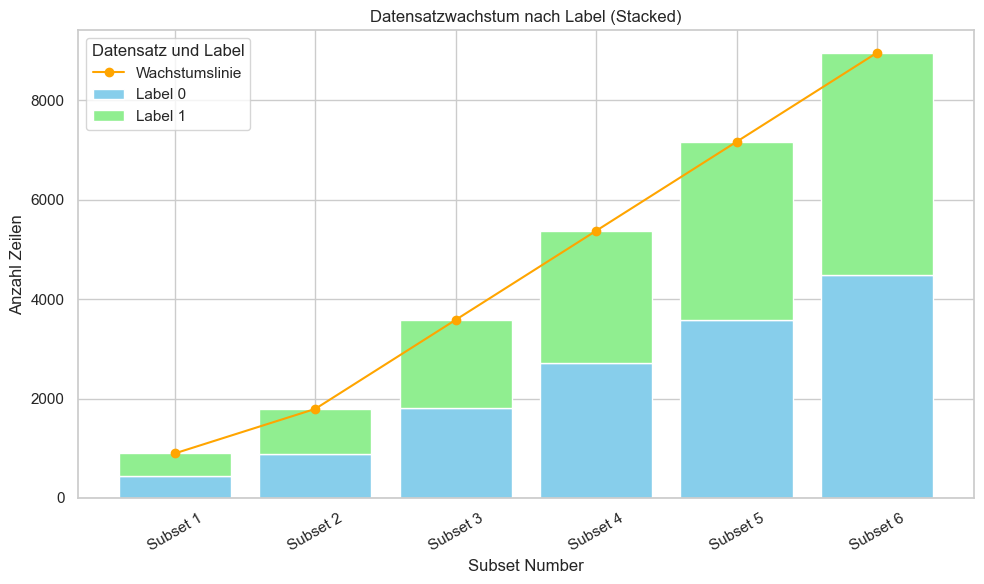

In [ ]:
nested_splits = create_nested_train_splits_stratified(df_train_final)
plot_label_distribution_over_splits_stacked(nested_splits)

Die Grafik veranschaulicht das schrittweise Wachstum der hierarchisch aufgebauten Trainingssplits, getrennt nach Sentiment-Labeln, und zeigt, dass das Verhältnis zwischen Label 0 und Label 1 über alle Subsets hinweg weitgehend konstant bleibt - eine wichtige Voraussetzung für faire Modellvergleiche.

In [ ]:
# Laden der Pickle datei 

with open("data/nested_splits.pkl", "rb") as f:
    nested_splits = pickle.load(f)

print("nested_splits erfolgreich geladen.")

nested_splits erfolgreich geladen.


##  Baseline-Modelle und Trainingsstrategien

### 1. Übersicht über die Modellierungsansätze

Zur Bewertung der Textklassifikationsleistung unter variierenden Datenmengen wurden drei modellbasierte Ansätze entwickelt. Die Implementierung erfolgte im bereitgestellten Notebook src/baseline.py.

Fine-Tuning: Hier kam bei jedem Split eine stratifizierte Aufteilung in Trainings-, Validierungs- und Testset zum Einsatz, um Hyperparameter abzustimmen und Overfitting frühzeitig zu erkennen.
Feature Extraction & Pseudo-Labeling: In diesem Schritt wurde kein zusätzlicher Validierungsdatensatz verwendet. Stattdessen wurden die LR-Hyperparameter einmal global über alle Daten (Nested Split) gewählt, und die finale Bewertung erfolgte direkt auf dem Testset mithilfe einer Cross-Validation.

Alle Methoden nutzen denselben zugrundeliegenden Klassifikationsdatensatz, unterscheiden sich jedoch deutlich im Umgang mit Sprachrepräsentationen und Trainingskomplexität.

---

### 2. Modellvarianten im Vergleich

#### (a) Klassisches Baseline-Modell: TF-IDF + Logistic Regression

Als einfachste Referenz wurde ein traditioneller Machine-Learning-Ansatz eingesetzt. Die Texte werden mithilfe eines `TfidfVectorizer` in eine numerische Repräsentation überführt. Diese Vektoren, eine gewichtete Frequenzdarstellung von Tokens, werden anschließend mit einem `LogisticRegression`-Modell klassifiziert.

**Merkmale:**

- Keine Nutzung von Kontextinformationen oder vortrainierten Sprachmodellen  
- Sehr geringe Rechenanforderung  
- Dient als Ausgangspunkt zur Bewertung leistungsfähigerer Modelle  

---

####  (b) Feature Extraction mit DistilBERT

Hierbei wird das vortrainierte Sprachmodell `distilbert-base-uncased` verwendet, um für jeden Text semantische Embeddings zu erzeugen. Das Modell bleibt dabei eingefroren. Es dient lediglich der Merkmalsextraktion.

- Die Embeddings werden durch *Mean Pooling* der Token-Repräsentationen im letzten Hidden Layer berechnet.
- Diese Vektoren dienen als Input für eine separate `LogisticRegression`, die auf Basis der extrahierten Features trainiert wird.
- Vorteil: Nutzung kontextueller Sprachinformationen ohne teures Fine-Tuning.

---

####  (c) Fine-Tuning von DistilBERT

In der dritten Variante wird `distilbert-base-uncased` vollständig auf die Zielaufgabe feinjustiert. Das gesamte Modell (inklusive Sprachencoder) wird weitertrainiert. Für das Training kommt die API von Hugging Face zum Einsatz.

- Das Modell lernt aufgaben- und domänenspezifische Repräsentationen.
- Höherer Rechenaufwand, aber meist bessere Leistung bei ausreichend Daten.
- Validierungsdaten werden verwendet, um das beste Modell (nach F1) zu speichern.

> **Hinweis:**  
> Aus Zeitgründen wurde beim Fine-Tuning lediglich ein Ansatz entwickelt, welcher noch weiter optimiert werden könnte. 

---

### 3. Tokenisierung und Datenaufbereitung

Für die Modelle auf BERT-Basis wurde `AutoTokenizer` aus der `transformers`-Bibliothek verwendet. Die Texte wurden dabei in gleichlange Sequenzen (max. 512 Tokens) umgewandelt, wobei zu lange Eingaben abgeschnitten wurden.

Die Aufteilung in Trainings-, Validierungs- und Testdaten erfolgt innerhalb jedes *Nested Splits* mit stratifizierter Verteilung, sodass die Klassenverhältnisse in allen Teilmengen gewahrt bleiben.

---

### 4. Hyperparameter und Ausführungsdetails

| Modell                | Hauptparameter                                                                 |
|----------------------|----------------------------------------------------------------------------------|
| TF-IDF + LR          | `max_iter=1000`, `max_features=5000`                                            |
| Feature Extraction   | DistilBERT frozen, Mean Pooling, `LogisticRegression` mit Standardparametern    |
| Fine-Tuning          | `epochs=5`, `lr=2e-5`, `batch_size=8`, Mixed Precision (wenn CUDA verfügbar)    |

Alle Trainingsläufe wurden lokal durchgeführt. Das beste Fine-Tuned-Modell wurde automatisch anhand der höchsten F1 auf der Validierungsmenge gespeichert.

---

### 5. Zielsetzung der Evaluation

Die Evaluation verfolgt das Ziel, die Wirkung verschiedener Trainingsstrategien zu analysieren. Folgende Fragen standen im Fokus:

- Wie viel Leistungsgewinn bringt der Einsatz vortrainierter Sprachmodelle gegenüber klassischen Verfahren?
- Reicht die reine Feature-Extraktion aus, oder ist vollständiges Fine-Tuning erforderlich?
- Wie wirkt sich die Größe des Trainingsdatensatzes auf die Modellleistung aus?

---

### 6. Bewertungsmetriken

Für die Bewertung der Modelle wurden die folgenden Metriken verwendet:

- **Accuracy**: Anteil korrekter Vorhersagen im Verhältnis zur Gesamtmenge  
- **F1-Score (weighted)**: Gewichteter Mittelwert von Precision und Recall, unter Berücksichtigung der Klassenverteilung 
- **Precision**: Anteil der korrekt als positiv klassifizierten Samples an allen als positiv vorhergesagten
- **Recall**: Anteil der korrekt als positiv klassifizierten Samples an allen tatsächlich positiven Samples 

> Zusätzlich wurden **Lernkurven** erstellt, die den Leistungszuwachs der Modelle über verschiedene Split-Größen hinweg visualisieren.


### Evaluierung der Modelle

In [ ]:
evaluate_baseline_results(
    json_path="../MC2/results/tfidf/tfidf_results.json",
    method_name="TF-IDF"
)

evaluate_baseline_results(
    json_path="../MC2/results/feature_extraction/feature_extraction_results.json",
    method_name="Feature Extraction"
)

evaluate_baseline_results(
    json_path="../MC2/results/fine_tuning/fine_tuning_results.json",
    method_name="Fine-Tuning"
)


Evaluation der Baseline-Ergebnisse – Methode: TF-IDF
----------------------------------------------------------------------
Split 0.1:
Accuracy : 0.8056
Precision: 0.8056
Recall   : 0.8056
F1-Score : 0.8055
----------------------------------------------------------------------
Split 0.2:
Accuracy : 0.8050
Precision: 0.8091
Recall   : 0.8050
F1-Score : 0.8046
----------------------------------------------------------------------
Split 0.4:
Accuracy : 0.8536
Precision: 0.8536
Recall   : 0.8536
F1-Score : 0.8536
----------------------------------------------------------------------
Split 0.6:
Accuracy : 0.8188
Precision: 0.8196
Recall   : 0.8188
F1-Score : 0.8186
----------------------------------------------------------------------
Split 0.8:
Accuracy : 0.8501
Precision: 0.8501
Recall   : 0.8501
F1-Score : 0.8501
----------------------------------------------------------------------
Split 1.0:
Accuracy : 0.8645
Precision: 0.8645
Recall   : 0.8645
F1-Score : 0.8645
----------------------

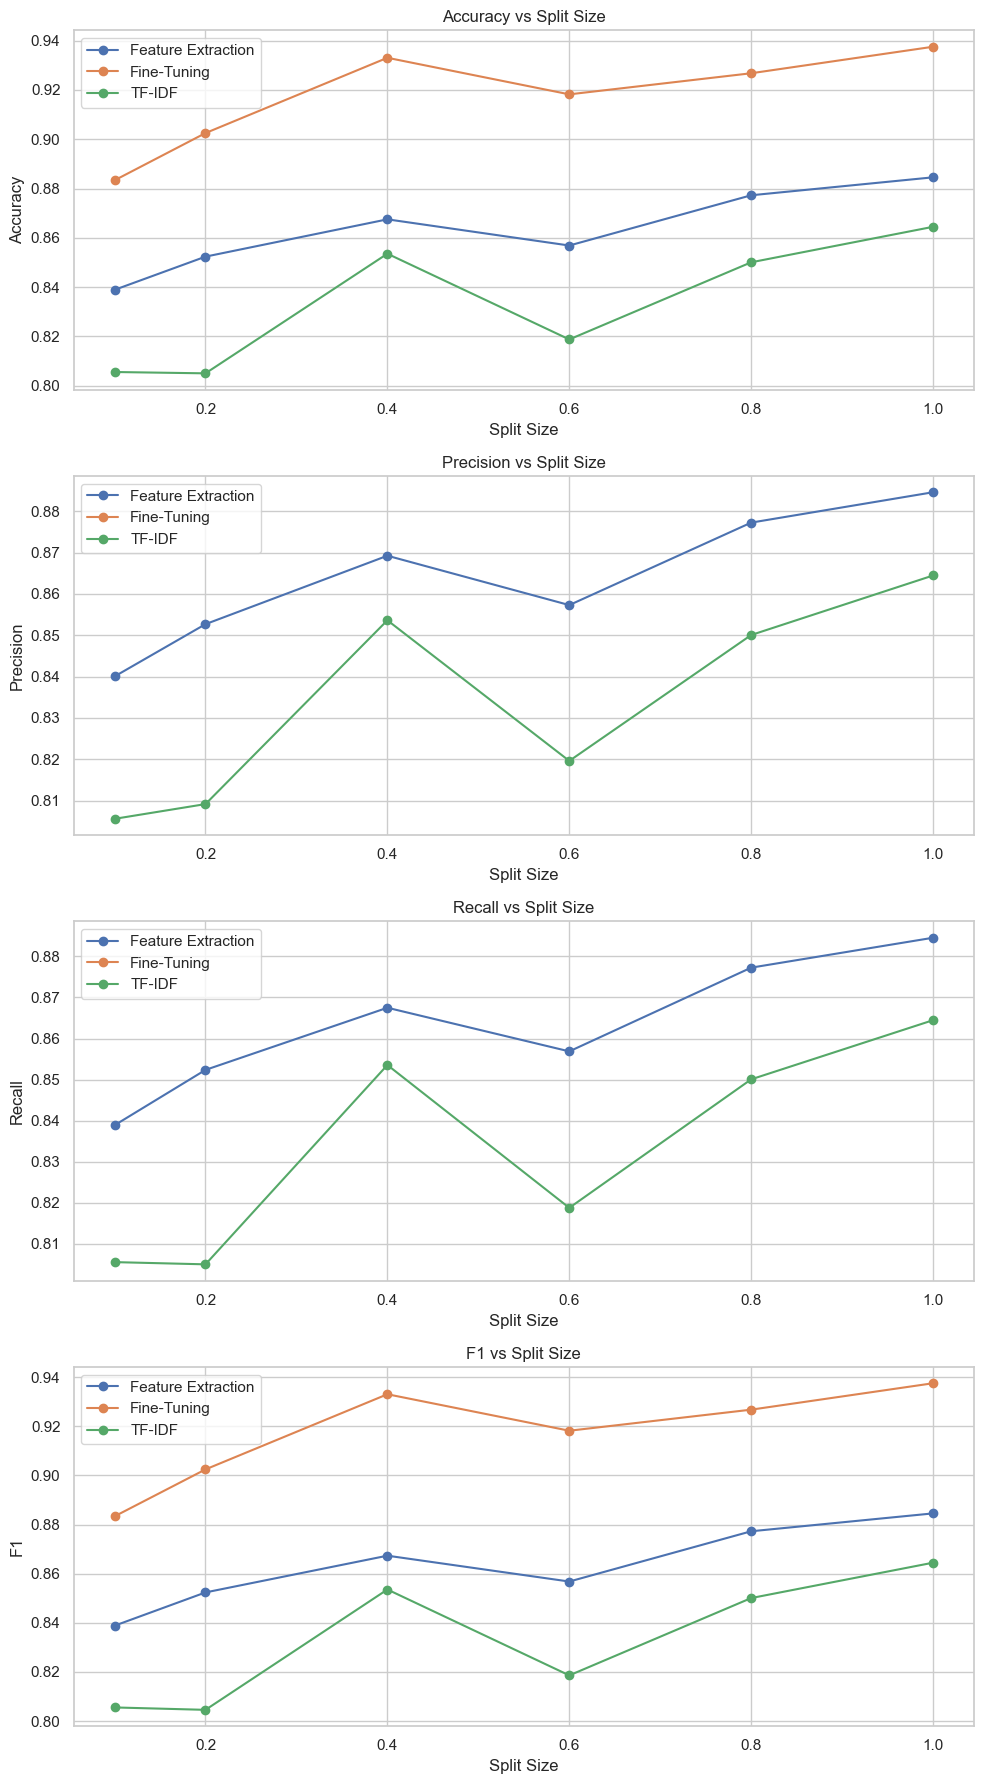

In [ ]:
json_paths_with_names = [
    ("../MC2/results/tfidf/tfidf_results.json", "TF-IDF"),
    ("../MC2/results/feature_extraction/feature_extraction_results.json", "Feature Extraction"),
    ("../MC2/results/fine_tuning/fine_tuning_results.json", "Fine-Tuning"),
]

df_comparison = baseline_evaluation_plot(json_paths_with_names)


###  Fazit: Vergleich der Modellierungsansätze

Die vier dargestellten Lernkurven (Accuracy, Precision, Recall, F1) liefern konsistente Ergebnisse über alle Metriken hinweg. Sie zeigen deutlich, wie sich die Modellgüte mit wachsender Split-Größe (Trainingsdatenmenge) entwickelt und welche Modellstrategie sich in welchem Szenario besonders lohnt.

---

####  Hauptbeobachtungen

1. **Fine-Tuning erzielt die höchste Gesamtleistung**  
   Der vollständig feinjustierte DistilBERT erreicht durchgehend die besten Werte bei Accuracy und F1, selbst bei kleineren Datenmengen (z. B. 0.2). Besonders bemerkenswert ist, dass das Fine-Tuned-Modell bei **0.4 Split-Größe bereits über 93 % Accuracy und F1** erreicht und sich bei 1.0 nochmals leicht verbessert.

2. **Feature Extraction zeigt starke, stabile Leistung**  
   Ohne Fine-Tuning, aber mit vortrainierten DistilBERT-Embeddings, liefert die Feature-Extraction-Methode durchweg solide Ergebnisse.  
   - Sie übertrifft die klassische TF-IDF-Variante **deutlich in allen Metriken**.  
   - Besonders bei geringen Split-Größen bleibt die Leistung **relativ stabil** und profitiert sichtbar von den kontextuellen Repräsentationen.

3. **TF-IDF bleibt konkurrenzfähig bei großen Datenmengen**  
   Die klassische Methode liefert im Vergleich die schwächsten Ergebnisse, insbesondere bei kleineren Trainingsmengen.  
   - Erst ab etwa **0.8 oder 1.0 Split Size** nähert sich die Leistung in F1 und Accuracy der Feature-Extraction-Variante an.  
   - Die einfache Modellarchitektur ist schnell trainierbar, aber limitiert durch fehlende Sprachverständnisfähigkeiten.

---

####  Gesamtbewertung

| Methode               | Kleine Datenmenge (≤ 0.4) | Große Datenmenge (≥ 0.8) | Trainingsaufwand | Leistungsniveau |
|-----------------------|---------------------------|---------------------------|------------------|------------------|
| **TF-IDF**            | Schwach                   | Mäßig                     | Gering           | Grundlinie       |
| **Feature Extraction**| Robust                    | Gut                       | Mittel           | Hoch             |
| **Fine-Tuning**       | Sehr gut                  | Exzellent                 | Hoch             | Sehr hoch        |

---

#### Schlussfolgerung

- **Fine-Tuning ist der leistungsstärkste Ansatz**, insbesondere wenn ausreichend Rechenressourcen vorhanden sind.
- **Feature Extraction bietet ein starkes Preis-Leistungs-Verhältnis** für Szenarien mit begrenztem Budget oder bei schnellem Iterationsbedarf.
- **TF-IDF** bleibt ein nützliches Referenzmodell, verliert aber im Vergleich zu modernen Sprachmodellen rasch an Relevanz – besonders bei begrenzten Datenmengen.



##  Erstellung und Visualisierung semantischer Text-Embeddings mit `all-MiniLM-L6-v2`

### Zielsetzung

Das Ziel dieses Schritts besteht darin, für gegebene Textdaten dichte, semantisch aussagekräftige Vektor-Repräsentationen (**Embeddings**) zu erzeugen. Diese Embeddings bilden die inhaltliche Bedeutung eines Textes in einem kontinuierlichen, hochdimensionalen Raum ab. Dadurch wird es möglich, Texte maschinell zu vergleichen, zu clustern oder als Eingabe für nachgelagerte Klassifikationsmodelle zu verwenden.

---

### Verwendetes Modell: `all-MiniLM-L6-v2`

Das Modell `all-MiniLM-L6-v2` stammt aus der `sentence-transformers`-Bibliothek und wurde speziell für die effiziente Erzeugung von Sentence-Embeddings entwickelt. Es handelt sich um ein kompaktes, aber leistungsfähiges Modell, das eine gute Balance zwischen **Genauigkeit** und **Rechenzeit** bietet.

#### Modellspezifikationen

| Merkmal                     | Beschreibung                                                       |
|-----------------------------|---------------------------------------------------------------------|
| **Modellname**              | `all-MiniLM-L6-v2`                                                 |
| **Bibliothek**              | [`sentence-transformers`](https://www.sbert.net/)                  |
| **Embedding-Dimension**     | 384                                                               |
| **Architektur**             | MiniLM (kompakte Transformer-Architektur)                          |
| **Trainiert auf**           | Natural Language Inference (NLI), Paraphrasen, STS-Daten           |
| **Stärken**                 | Schnell, speichereffizient, gute semantische Generalisierung       |
| **Einsatzbereiche**         | Semantische Suche, Klassifikation, Clustering, Textähnlichkeit     |

Das Modell erzeugt pro Eingabetext einen Vektor mit 384 Dimensionen, der die semantische Bedeutung des Textes abbildet. Bedeutungsähnliche Texte liegen im Vektorraum näher beieinander.

---

### Visualisierung mit t-SNE

Zur Analyse und Veranschaulichung der Embeddings wurde das Verfahren **t-SNE** (*t-distributed Stochastic Neighbor Embedding*) eingesetzt. Es reduziert hochdimensionale Daten (hier: 384D) auf zwei Dimensionen, sodass diese visuell interpretierbar werden.

#### Warum t-SNE?

- Reduktion der Dimensionalität auf 2D für Visualisierung
- Bewahrt lokale Struktur (Nachbarschaften)
- Zeigt Trennbarkeit und Clusterbildung semantischer Gruppen


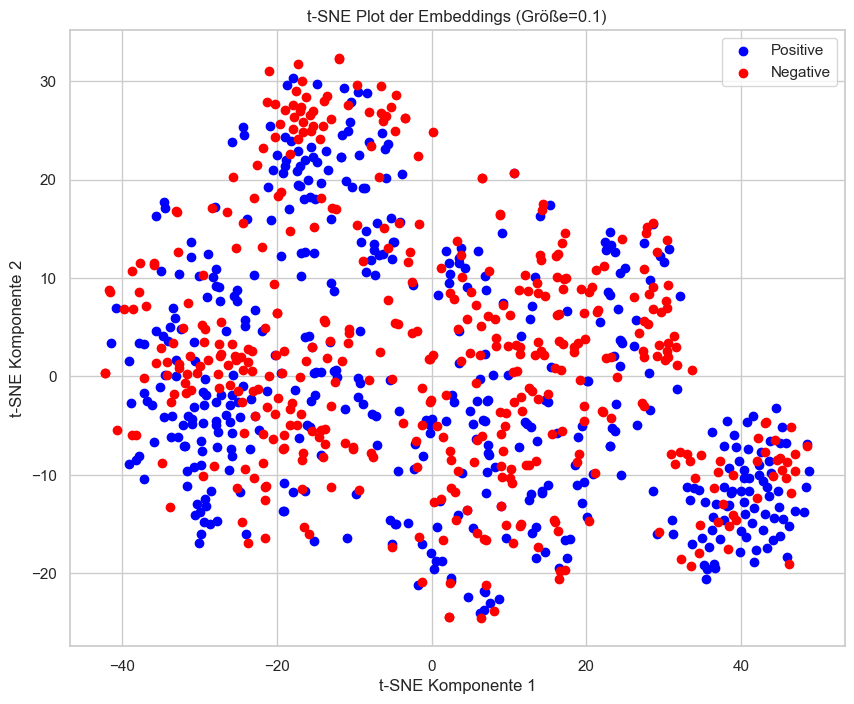

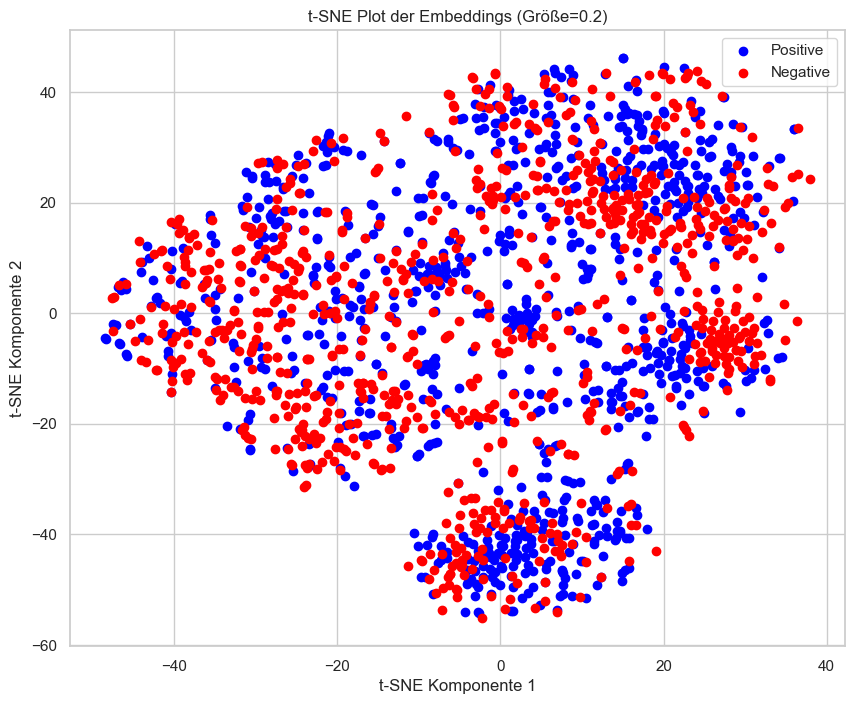

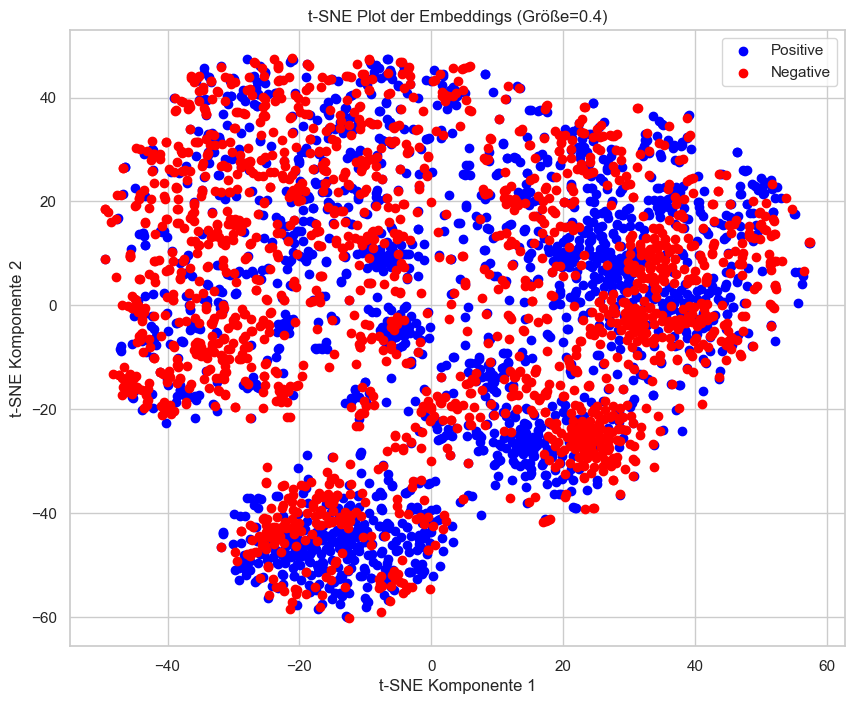

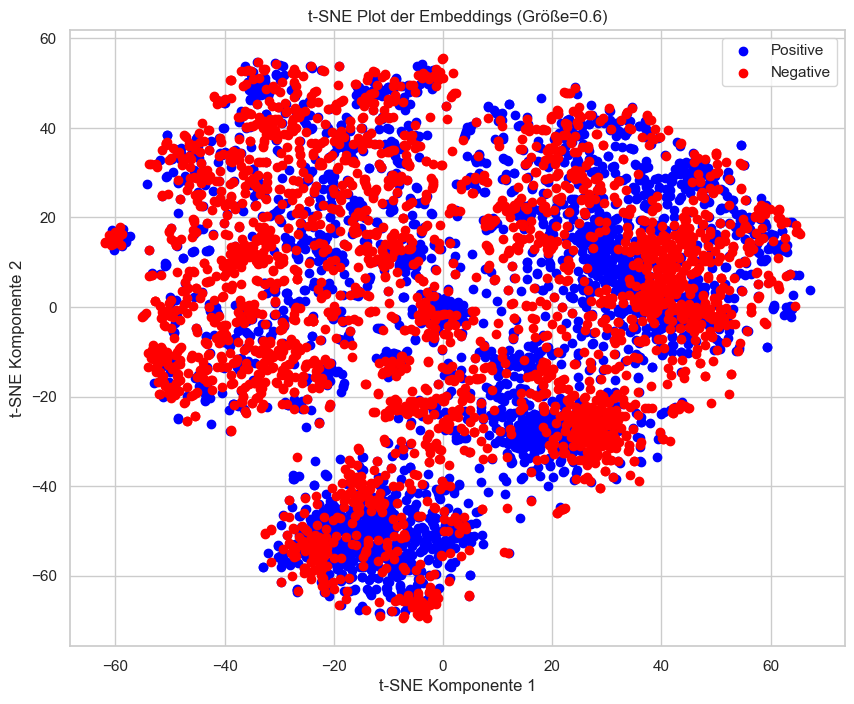

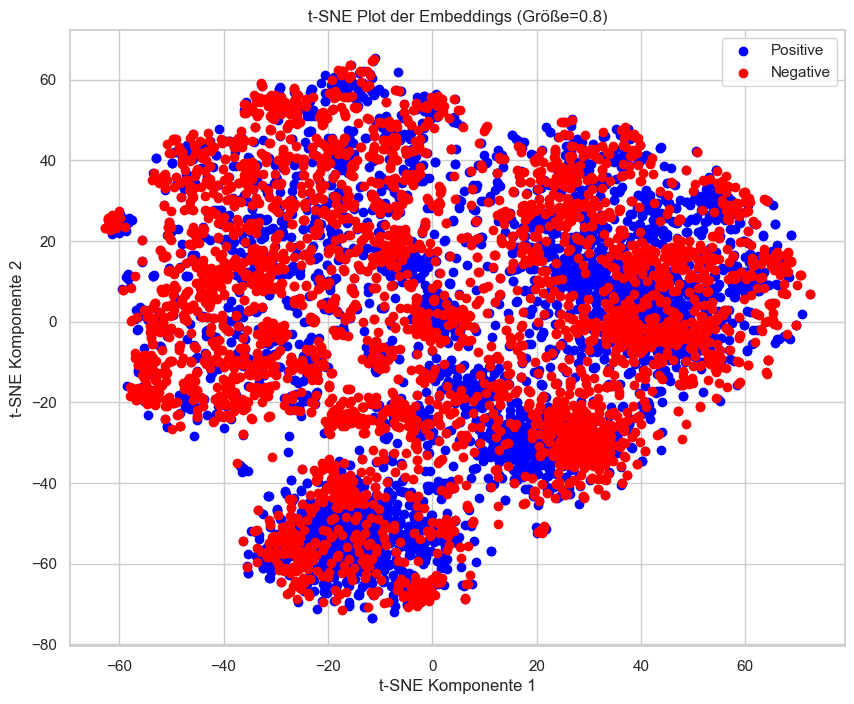

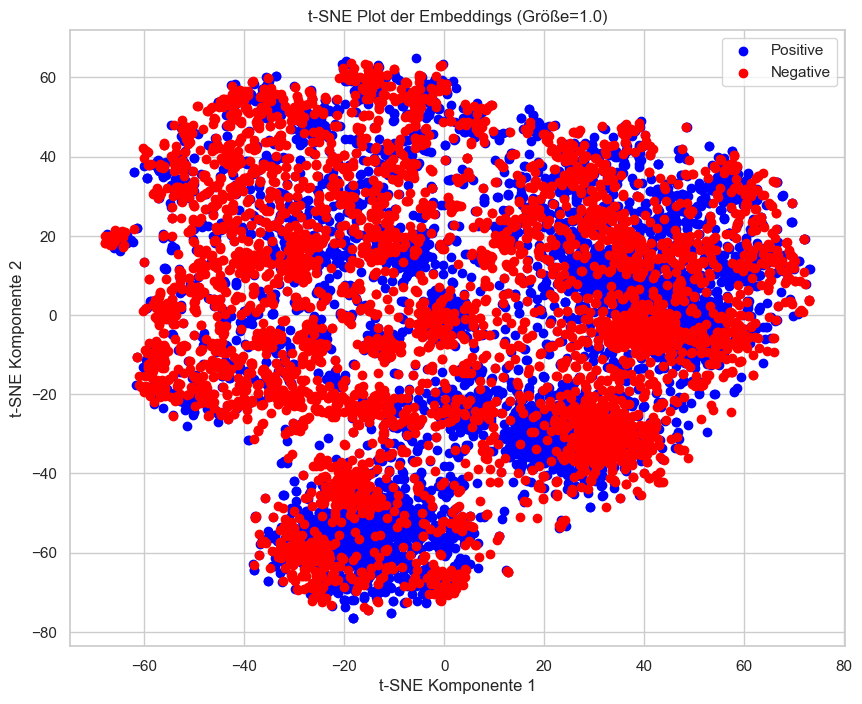

In [ ]:
plot_tsne_for_all_embeddings(
    splits=nested_splits,
    prefix="train",
    output_path="outputs/embeddings"
)

Die t-SNE-Plots visualisieren die semantischen Embeddings der Texte im zweidimensionalen Raum.   
Jeder Punkt repräsentiert einen Text, wobei die Farbe dessen Sentimentlabel angibt – blau für positiv, rot für negativ.  
Die verschiedenen Grafiken zeigen t-SNE-Reduktionen für unterschiedliche Datengrößen.  

**Beobachtungen:**
* **Zunehmende Datenmenge** -> dichtere und komplexere Struktur:  
Mit wachsendem Datensatz (Größe 0.1 - 1.0) wird die Verteilung der Punkte dichter und die Clusterbildung klarer.  
Dies zeigt, dass mehr Daten zu vielfältigeren semantischen Kontexten führen, was sich in der Embedding-Struktur niederschlägt.

* **Keine klar trennbaren Sentiment-Cluster:**  
Positive und negative Texte überlappen stark – selbst bei größeren Datenmengen. Dies weist darauf hin, dass die semantische Ähnlichkeit allein oft nicht ausreicht, um Sentiment zuverlässig zu trennen.  
Einzelne kleinere Subcluster mit homogener Farbverteilung deuten jedoch an, dass es Textgruppen mit eindeutiger Sentimentzuordnung gibt (zB. stark emotional gefärbte Aussagen).  

* **Lokal sinnvolle Struktur, global vermischt:**  
t-SNE bewahrt lokale Nachbarschaften: ähnliche Texte liegen nahe beieinander. Global (zB. ganze Klassen) lässt sich jedoch keine saubere Trennung erkennen.  
Das ist typisch für semantische Embeddings, da sie nicht primär für Sentimentoptimierung trainiert wurden. 

* **Implikationen für Weak Labelling:**  
Die beobachteten Cluster lassen vermuten, dass lokal basierte Weak-Labeling-Methoden (zB. KNN oder Centroid-Verfahren) vielversprechend sind.  
Die starke Überlappung weist jedoch auf eine gewisse Unsicherheit bei automatisch generierten Labels hin – besonders bei Texten, die semantisch mehrdeutig oder neutral formuliert sind.  

# Weak labels  

Weak Labelling ist ein Verfahren im Bereich der Sentimentanalyse, bei dem automatisch geschätzte (und potenziell fehlerhafte) Labels für unannotierte Daten erzeugt werden. Dies geschieht durch den Einsatz von heuristischen Regeln, externen Wissensquellen oder semi-supervised Learning. Ziel ist es, große Mengen an Trainingsdaten bereitzustellen, ohne kostenintensive manuelle Annotation durchführen zu müssen. Die so erzeugten Labels dienen anschließend zum Trainieren von Machine-Learning-Modellen – besonders dann, wenn nur wenige manuell gelabelte Daten vorhanden sind.

Die verschiedenen Weak-labeling-Techniken sowie deren Functions zur Evaluierung der Ergebnisse wurden in `weak_label.py` ausgelagert welcher sich im Ordner `src`befindet.

### Generierung Weak labels

**Methoden**:

#### **Centroid-Matching mit Sentence Embeddings**:  
Diese Methode basiert auf semantischen Satzrepräsentationen mittels SBERT-Embeddings. Pro Klasse wird ein **Zentroid** berechnet – also der durchschnittliche Vektor aller hard-gelabelten Beispiele dieser Klasse.

**Ablauf:**
- Embeddings der gelabelten Texte generieren
- Pro Klasse den Mittelwert der Embeddings berechnen
- Für jeden unlabelten Text die Cosine Similarity zu allen Klassen-Centroids berechnen
- Die Klasse mit der höchsten Ähnlichkeit wird als Weak Label zugewiesen

**Vorteile:**
- Sehr effizient und einfach zu implementieren  
- Keine Hyperparameter notwendig  
- Gut skalierbar für große Datensätze

**Nachteile:**
- Kann bei komplexen oder überlappenden Klassenstrukturen ungenauer sein

---

#### **Zero-Shot Classification mit NLI-Modellen (BART)**:  
Mit Hilfe eines vortrainierten NLI-Modells wie `facebook/bart-large-mnli` werden Texte **ohne Training** klassifiziert. Es werden Hypothesen wie "Der Text ist positiv" bzw. "Der Text ist negativ" gebildet, und das Modell bewertet, welche Hypothese am wahrscheinlichsten zutrifft.

**Ablauf:**
- Für jeden Text werden Klassenzugehörigkeits-Hypothesen formuliert
- Das Modell berechnet Entailment-Wahrscheinlichkeiten für jede Hypothese
- Die Klasse mit der höchsten Wahrscheinlichkeit wird übernommen

**Vorteile:**
- Kein Training nötig  
- Sofort einsatzbereit auch ohne gelabelte Daten  
- Funktioniert gut bei kleinen Datensätzen

**Nachteile:**
- Domänenspezifische Ausdrücke oder Ironie können falsch interpretiert werden  
- Qualität hängt stark vom vortrainierten Modell ab

---

#### **KNN mit SBERT-Embeddings (instanzbasierte Klassifikation)**:  
Diese Methode verwendet semantische Sentence Embeddings aus einem vortrainierten Modell (all-MiniLM-L6-v2), um die Ähnlichkeit zwischen unlabelten und hart gelabelten Texten zu berechnen. Auf dieser Basis wird ein k-Nearest Neighbors (KNN)-Klassifikator trainiert, der jedem unbeschrifteten Text das Label der nächstgelegenen gelabelten Nachbarn zuweist.

**Ablauf:**
- Sentence Embeddings für alle harten und unlabelten Texte generieren
- Ein KNN-Modell (mit k= 3–10, dynamisch je nach Trainingsmenge) auf den Embeddings der hart gelabelten Texte trainieren 
- Für jeden unlabelten Text werden die k nächsten Nachbarn ermittelt (basierend auf Cosine Similarity) 
- Das Mehrheitslabel der Nachbarn wird als Weak Label übernommen

**Vorteile:**
- Nutzt semantische Nähe statt bloßer Schlüsselwörter 
- Sehr flexibel – benötigt nur minimale Modellanpassung 
- Durch dynamisches k auch für kleine Labelmengen robust
- Gut interpretierbar: "Label durch ähnliche bekannte Texte"

**Nachteile:**
- Rechenintensiv bei vielen Texten (Embedding + Nachbarsuche)
- Instabil bei stark überlappenden Klassen oder unbalancierten Nachbarschaften
- Performance hängt stark von Embedding-Qualität und Nachbarschaftsstruktur ab

---

#### **Random Forest Weak Labeling mit adaptivem Confidence-Threshold**
Diese Methode verwendet einen überwachten Klassifikator (RandomForest), um aus den harten Labels ein Modell zu lernen, das dann auf unbeschriftete Texte angewendet wird. Dabei wird pro Vorhersage die jeweilige Modellkonfidenz berücksichtigt – ein adaptiver Threshold wird automatisch gewählt, um ein möglichst ausgewogenes Verhältnis der vorhergesagten Klassen (0/1) sicherzustellen.

**Ablauf:**
* Die hart gelabelten Texte werden mit einem TfidfVectorizer in numerische Merkmale umgewandelt
* Ein RandomForestClassifier wird auf diesen Features trainiert
* Das Modell gibt für alle unbeschrifteten Texte Vorhersagen inklusive Konfidenzwert (maximale Klassenwahrscheinlichkeit)
* Es wird ein optimaler Confidence-Threshold im Bereich 0.6–0.95 gesucht, bei dem das Verhältnis zwischen Klasse 0 und Klasse 1 in den Weak Labels möglichst nahe an 50/50 liegt
* Alle Vorhersagen mit einer Konfidenz über dem Schwellenwert werden als Weak Labels übernommen, der Rest wird verworfen

**Logik für Schwellenwert-wahl:**  
* Thresholds werden schrittweise durchlaufen (step = 0.01)
* Für jeden Schwellenwert wird berechnet, wie viele 0er und 1er akzeptiert würden
* Der Threshold mit der höchsten Klassengleichverteilung (|Anteil_0 - Anteil_1| -> min) wird gewählt

**Vorteile:**
* Nutzt die Stärke eines überwachten Lerners ohne komplettes Training auf allen Daten
* Automatisierte Threshold-Wahl führt zu besserer Label-Balance
* Liefert oft präzise und robuste Labels, insbesondere bei ausreichender Menge harter Labels
* Gut geeignet für größere Trainingsmengen, da Random Forest stabil und interpretierbar ist

**Nachteile:**
* Bei sehr kleinen Splits oder extrem einseitigen Trainingsdaten kann keine gute Trennung erfolgen
* Threshold-Wahl kann bei sehr unsicheren Modellen zu vielen verworfenen Labels führen
* Erfordert ausreichend Trainingsbeispiele beider Klassen

**Hinweis:**  
Diese Methode wurde speziell angepasst, um eine Schwäche früherer RF-Versuche zu beheben, bei denen häufig nur eine Klasse (zB. 1) vorhergesagt wurde. Durch die automatische Wahl eines Thresholds, der zu einer ausgewogenen Klassenverteilung führt, entsteht eine klar verbesserte Grundlage für Training und Analyse.

---

#### **Heuristik-basierte Weak Labeling Methode (mit gewichteter Mehrheitsabstimmung)**
Diese Methode verwendet manuell definierte Labeling Functions (LFs) auf Basis häufig vorkommender Begriffe und Phrasen mit positivem oder negativem Sentiment. Jede LF gibt ein Label zurück (POSITIVE, NEGATIVE oder ABSTAIN), falls bestimmte sprachliche Muster im Text erkannt werden. Durch gewichtete Mehrheitsabstimmung werden die Vorschläge der LFs zu einem finalen Label kombiniert.

**Ablauf:**
* Entwicklung mehrerer LFs (auf Basis polarisiernder Wörter oder Phrasen)
* Jeder LF wird ein Gewicht zugewiesen (zB. 1.0 für lf_sentiment_phrases, 0.5 für Keyword-LFs)
* Pro unlabeltem Text aggregieren die LFs ihre Vorschläge über gewichtete Mehrheitsabstimmung
* Falls keine LF anspricht -> ABSTAIN
* Abschließend werden alle ABSTAINs entfernt (bei Splitsize 1.0 wird die Anzahl ausgegeben)

**Hinweis:**  
Die Labeling Functions wurden auf Basis der Ergebnisse der vorherigen explorativen Datenanalyse (EDA) entworfen. Dabei wurden Wörter und Phrasen identifiziert, die signifikant häufiger in positiv oder negativ gelabelten Texten vorkamen. Daraus wurden drei zentrale LFs abgeleitet:  
1) lf_positive_keywords: erkennt einzelne positive Begriffe wie great, love, excellent,
2) lf_negative_keywords: erkennt negative Begriffe wie waste, bad, disappointed
3) lf_sentiment_phrases: erkennt starke Phrasen wie absolutely love, waste of money, not good, five stars

Auf kontextabhängige Begriffe wie "would" wurde bewusst verzichtet, da sie ohne sprachlichen Zusammenhang keine eindeutige Aussagekraft besitzen.  
Ebenso wurde keine LF auf Basis von Textlängen oder anderen syntaktischen Eigenschaften erstellt, da EDA gezeigt hat, dass zwischen positiven und negativen Texten kein wesentlicher Längenunterschied besteht.  
Zusätzlich wurde lf_sentiment_phrases bewusst stärker gewichtet, da zusammengesetzte Ausdrücke wie "would not recommend" oder "five stars" meist sehr zuverlässig das Sentiment anzeigen.

**Vorteile:**
* Vollständig transparent und nachvollziehbar
* Keine Black-Box-Komponente, rein regelbasiert
* Modular und gut erweiterbar mit domänenspezifischem Wissen
* Schnell und ohne Training einsetzbar
* Durch Gewichtung justierbar

**Nachteile:**
* Erfordert initialen Aufwand zur Entwicklung sinnvoller LFs
* Qualität stark abhängig von Vielfalt und Qualität der LFs
* Geringere Performance, wenn LFs sehr redundant oder zu ungenau sind
* Regeln greifen nicht bei komplexem Sprachgebrauch oder Ironie
* Kein echtes Kontextverständnis -> zB. „not bad“ muss manuell als positiv berücksichtigt werden

---



**Vorbereitung der Daten für Weak Labelling**

Für die Durchführung des Weak Labelling basieren alle weiteren Schritte auf den zuvor erstellten **nested splits** des Trainingsdatensatzes. Diese Splits sind hierarchisch aufgebaut – das heißt: jeder größere Split enthält alle Datenpunkte der kleineren. Dadurch können Modelle mit wachsendem Datenumfang systematisch evaluiert werden.

Um die Anwendung von Weak Labelling realistisch zu simulieren, wird pro Split ein definierter Anteil der Daten (%) als **"hard-gelabelt"** beibehalten, während der Rest als **"unlabeled"** behandelt wird. Diese Trennung erfolgt **stratifiziert**, also unter Berücksichtigung der ursprünglichen Labelverteilung. So wird sichergestellt, dass sowohl der gelabelte als auch der unlabelte Teil weiterhin eine **ausgeglichene Klassenverteilung** aufweisen.

Die zentrale Idee dabei ist:  
Nur ein kleiner Teil der Daten steht als echte (manuell annotierte) Labels zur Verfügung – der Rest muss mithilfe von Weak Labelling automatisiert beschriftet werden.

Zur Qualitätssicherung wird in jedem Split das ursprüngliche Label aller Datenpunkte zusätzlich in einer separaten Spalte (`true_label`) mitgeführt.  
Dies ermöglicht eine spätere **gezielte Evaluierung der Qualität der generierten Weak Labels**, indem sie direkt mit dem Ground Truth verglichen werden können.

Zusätzlich wird in einer weiteren Spalte (`label_type`) festgehalten, ob ein Text **"hard"** (ursprünglich gelabelt) oder **"unlabeled"** (weak gelabelt oder noch unbeschriftet) ist.

Diese einheitliche Struktur schafft die Grundlage dafür, dass alle Weak Labelling Methoden im Projekt – wie zB. Zero-Shot Classification, Centroid-Matching oder VADER – auf die gleichen Splits angewendet und anschließend fair verglichen werden können.

In [ ]:
semi_splits = create_semi_supervised_splits_ratio_combined(nested_splits, label_ratio=0.2)

# Zugriff auf Split 0.2
df_split_20 = semi_splits[0.2]

# Ausgabe prüfen
print(df_split_20['label_type'].value_counts())
print(df_split_20.head(3))


label_type
unlabeled    1434
hard          358
Name: count, dtype: int64
                                                text  label weak_label  \
0  Excellent : As a fine artist by day, I wanted ...    1.0          1   
1  Who can grin and do this?!?!! : i bought this ...    1.0          1   
2  Excellent, what I have been needing : Since Br...    1.0          1   

  label_type  true_label  
0       hard           1  
1       hard           1  
2       hard           1  


## Centroid-Matching mit Sentence Embeddings

In [ ]:
labeled_splits_centroid = apply_centroid_weak_labelling_to_all_splits(semi_splits)

Verarbeite Split 0.1 mit Centroid-Matching...


Batches: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s]


Verarbeite Split 0.2 mit Centroid-Matching...


Batches: 100%|██████████| 45/45 [00:16<00:00,  2.75it/s]


Verarbeite Split 0.4 mit Centroid-Matching...


Batches: 100%|██████████| 90/90 [00:32<00:00,  2.76it/s]


Verarbeite Split 0.6 mit Centroid-Matching...


Batches: 100%|██████████| 135/135 [00:47<00:00,  2.86it/s]


Verarbeite Split 0.8 mit Centroid-Matching...


Batches: 100%|██████████| 180/180 [01:02<00:00,  2.88it/s]


Verarbeite Split 1.0 mit Centroid-Matching...


Batches: 100%|██████████| 225/225 [01:22<00:00,  2.74it/s]


In [ ]:
inspect_weak_label_distribution(labeled_splits_centroid, method_name="centroid")


Label-Verteilung & Vollständigkeit – Methode: CENTROID
Split 0.1 – 896 Einträge
label_type-Verteilung:
label_type
weak    717
hard    179

weak_label-Verteilung:
weak_label
1    476
0    420

Final gelabelt: 896 von 896 | Fehlend: 0
----------------------------------------------------------------------
Split 0.2 – 1792 Einträge
label_type-Verteilung:
label_type
weak    1434
hard     358

weak_label-Verteilung:
weak_label
1    936
0    856

Final gelabelt: 1792 von 1792 | Fehlend: 0
----------------------------------------------------------------------
Split 0.4 – 3584 Einträge
label_type-Verteilung:
label_type
weak    2868
hard     716

weak_label-Verteilung:
weak_label
1    1817
0    1767

Final gelabelt: 3584 von 3584 | Fehlend: 0
----------------------------------------------------------------------
Split 0.6 – 5376 Einträge
label_type-Verteilung:
label_type
weak    4301
hard    1075

weak_label-Verteilung:
weak_label
1    2713
0    2663

Final gelabelt: 5376 von 5376 | Fehlend: 0


## KNN mit SBERT

In [ ]:
labeled_splits_knn = apply_knn_weak_labelling_to_all_splits(semi_splits, text_col='text')

Verarbeite Split 0.1 mit KNN-SBERT (k=3) auf 179 harten Beispielen...


Batches: 100%|██████████| 23/23 [00:08<00:00,  2.79it/s]


Verarbeite Split 0.2 mit KNN-SBERT (k=3) auf 358 harten Beispielen...


Batches: 100%|██████████| 45/45 [00:16<00:00,  2.65it/s]


Verarbeite Split 0.4 mit KNN-SBERT (k=7) auf 716 harten Beispielen...


Batches: 100%|██████████| 90/90 [00:32<00:00,  2.79it/s]


Verarbeite Split 0.6 mit KNN-SBERT (k=10) auf 1075 harten Beispielen...


Batches: 100%|██████████| 135/135 [00:49<00:00,  2.75it/s]


Verarbeite Split 0.8 mit KNN-SBERT (k=10) auf 1433 harten Beispielen...


Batches: 100%|██████████| 180/180 [01:05<00:00,  2.76it/s]


Verarbeite Split 1.0 mit KNN-SBERT (k=10) auf 1792 harten Beispielen...


Batches: 100%|██████████| 225/225 [01:23<00:00,  2.70it/s]


In [ ]:
inspect_weak_label_distribution(labeled_splits_knn, method_name="KNN")


Label-Verteilung & Vollständigkeit – Methode: KNN
Split 0.1 – 896 Einträge
label_type-Verteilung:
label_type
weak    717
hard    179

weak_label-Verteilung:
weak_label
0    486
1    410

Final gelabelt: 896 von 896 | Fehlend: 0
----------------------------------------------------------------------
Split 0.2 – 1792 Einträge
label_type-Verteilung:
label_type
weak    1434
hard     358

weak_label-Verteilung:
weak_label
0    897
1    895

Final gelabelt: 1792 von 1792 | Fehlend: 0
----------------------------------------------------------------------
Split 0.4 – 3584 Einträge
label_type-Verteilung:
label_type
weak    2868
hard     716

weak_label-Verteilung:
weak_label
1    1935
0    1649

Final gelabelt: 3584 von 3584 | Fehlend: 0
----------------------------------------------------------------------
Split 0.6 – 5376 Einträge
label_type-Verteilung:
label_type
weak    4301
hard    1075

weak_label-Verteilung:
weak_label
0    2750
1    2626

Final gelabelt: 5376 von 5376 | Fehlend: 0
-----

## Zero-Shot Classifier (BART, 0/1 Labels)

In [ ]:
#labeled_splits_zero_shot = apply_zero_shot_to_all_splits(semi_splits)

Verarbeite Split 0.1 mit Zero-Shot...


Device set to use cpu
Zero-Shot Klassifikation: 100%|██████████| 717/717 [09:34<00:00,  1.25it/s]


Verarbeite Split 0.2 mit Zero-Shot...


Device set to use cpu
Zero-Shot Klassifikation: 100%|██████████| 1434/1434 [19:10<00:00,  1.25it/s]


Verarbeite Split 0.4 mit Zero-Shot...


Device set to use cpu
Zero-Shot Klassifikation: 100%|██████████| 2868/2868 [38:14<00:00,  1.25it/s]


Verarbeite Split 0.6 mit Zero-Shot...


Device set to use cpu
Zero-Shot Klassifikation: 100%|██████████| 4301/4301 [57:14<00:00,  1.25it/s] 


Verarbeite Split 0.8 mit Zero-Shot...


Device set to use cpu
Zero-Shot Klassifikation: 100%|██████████| 5735/5735 [1:16:57<00:00,  1.24it/s]


Verarbeite Split 1.0 mit Zero-Shot...


Device set to use cpu
Zero-Shot Klassifikation: 100%|██████████| 7169/7169 [1:31:52<00:00,  1.30it/s]


In [ ]:
# pickle laden
with open("../MC2/data_weak_labels/labeled_splits_zero_shot.pkl", "rb") as f:
    labeled_splits_zero_shot = pickle.load(f)

In [ ]:
inspect_weak_label_distribution(labeled_splits_zero_shot, method_name="Zero-Shot")


Label-Verteilung & Vollständigkeit – Methode: ZERO-SHOT
Split 0.1 – 896 Einträge
label_type-Verteilung:
label_type
weak    717
hard    179

weak_label-Verteilung:
weak_label
0    464
1    432

Final gelabelt: 896 von 896 | Fehlend: 0
----------------------------------------------------------------------
Split 0.2 – 1792 Einträge
label_type-Verteilung:
label_type
weak    1434
hard     358

weak_label-Verteilung:
weak_label
0    923
1    869

Final gelabelt: 1792 von 1792 | Fehlend: 0
----------------------------------------------------------------------
Split 0.4 – 3584 Einträge
label_type-Verteilung:
label_type
weak    2868
hard     716

weak_label-Verteilung:
weak_label
0    1879
1    1705

Final gelabelt: 3584 von 3584 | Fehlend: 0
----------------------------------------------------------------------
Split 0.6 – 5376 Einträge
label_type-Verteilung:
label_type
weak    4301
hard    1075

weak_label-Verteilung:
weak_label
0    2850
1    2526

Final gelabelt: 5376 von 5376 | Fehlend: 0

## Random Forest Classifier

In [ ]:
labeled_splits_rf = apply_rf_balanced_to_all_splits(semi_splits, text_col='text')


Verarbeite Split 0.1 mit adaptivem RF-Threshold...
Optimaler Threshold gewählt: 0.69 | Klassengleichgewicht: 1.00

Verarbeite Split 0.2 mit adaptivem RF-Threshold...
Optimaler Threshold gewählt: 0.60 | Klassengleichgewicht: 0.91

Verarbeite Split 0.4 mit adaptivem RF-Threshold...
Optimaler Threshold gewählt: 0.91 | Klassengleichgewicht: 1.00

Verarbeite Split 0.6 mit adaptivem RF-Threshold...
Optimaler Threshold gewählt: 0.68 | Klassengleichgewicht: 0.98

Verarbeite Split 0.8 mit adaptivem RF-Threshold...
Optimaler Threshold gewählt: 0.64 | Klassengleichgewicht: 0.99

Verarbeite Split 1.0 mit adaptivem RF-Threshold...
Optimaler Threshold gewählt: 0.66 | Klassengleichgewicht: 1.00


In [ ]:
inspect_weak_label_distribution(labeled_splits_rf, method_name="RF")


Label-Verteilung & Vollständigkeit – Methode: RF
Split 0.1 – 241 Einträge
label_type-Verteilung:
label_type
hard    179
weak     62

weak_label-Verteilung:
weak_label
1    122
0    119

Final gelabelt: 241 von 241 | Fehlend: 0
----------------------------------------------------------------------
Split 0.2 – 1031 Einträge
label_type-Verteilung:
label_type
weak    673
hard    358

weak_label-Verteilung:
weak_label
1    547
0    484

Final gelabelt: 1031 von 1031 | Fehlend: 0
----------------------------------------------------------------------
Split 0.4 – 718 Einträge
label_type-Verteilung:
label_type
hard    716
weak      2

weak_label-Verteilung:
weak_label
0    360
1    358

Final gelabelt: 718 von 718 | Fehlend: 0
----------------------------------------------------------------------
Split 0.6 – 2042 Einträge
label_type-Verteilung:
label_type
hard    1075
weak     967

weak_label-Verteilung:
weak_label
0    1039
1    1003

Final gelabelt: 2042 von 2042 | Fehlend: 0
---------------

## Heuristic Labeling

In [ ]:
labeled_splits_heuristic = apply_heuristics_to_all_splits(semi_splits, text_col='text')

Verarbeite Split 0.1 mit gewichteter Heuristik...
Verarbeite Split 0.2 mit gewichteter Heuristik...
Verarbeite Split 0.4 mit gewichteter Heuristik...
Verarbeite Split 0.6 mit gewichteter Heuristik...
Verarbeite Split 0.8 mit gewichteter Heuristik...
Verarbeite Split 1.0 mit gewichteter Heuristik...
→ ABSTAIN entfernt in Split 1.0: 2037 von 8961 (22.7%)


In [ ]:
inspect_weak_label_distribution(labeled_splits_heuristic, method_name="heuristic")


Label-Verteilung & Vollständigkeit – Methode: HEURISTIC
Split 0.1 – 688 Einträge
label_type-Verteilung:
label_type
weak    509
hard    179

weak_label-Verteilung:
weak_label
1    507
0    181

Final gelabelt: 688 von 688 | Fehlend: 0
----------------------------------------------------------------------
Split 0.2 – 1413 Einträge
label_type-Verteilung:
label_type
weak    1055
hard     358

weak_label-Verteilung:
weak_label
1    1046
0     367

Final gelabelt: 1413 von 1413 | Fehlend: 0
----------------------------------------------------------------------
Split 0.4 – 2815 Einträge
label_type-Verteilung:
label_type
weak    2099
hard     716

weak_label-Verteilung:
weak_label
1    2071
0     744

Final gelabelt: 2815 von 2815 | Fehlend: 0
----------------------------------------------------------------------
Split 0.6 – 4203 Einträge
label_type-Verteilung:
label_type
weak    3128
hard    1075

weak_label-Verteilung:
weak_label
1    3098
0    1105

Final gelabelt: 4203 von 4203 | Fehlend:

### Evaluierung Qualität Weak labels pre-training  

**Metriken zur Bewertung der Weak Label Qualität**

* **Accuracy:** Anteil korrekt gelabelter Beispiele insgesamt. Aussagekräftig bei balancierten Klassen

* **Precision:** Anteil korrekter positiver Vorhersagen. Wichtig, wenn False Positives vermieden werden sollen

* **Recall:** Anteil erkannter tatsächlicher positiver Beispiele. Relevant, wenn möglichst alle positiven Fälle erkannt werden sollen

* **F1-Score:** Harmonisches Mittel aus Precision und Recall. Guter Gesamtindikator für Labelqualität

* **Confusion Matrix:** Übersicht über True/False Positives und Negatives. Zeigt Fehlklassifizierungsmuster und Bias-Tendenzen

Ziel: Hoher F1-Score, ausgewogene Precision/Recall, möglichst wenige systematische Fehler in der Confusion Matrix.

In [ ]:
# Für KNN-basierte Weak Labels
evaluate_weak_labels_quality(labeled_splits_centroid, method_name="centroid")

# Für Zero-Shot-basierte Weak Labels
evaluate_weak_labels_quality(labeled_splits_zero_shot, method_name="Zero-Shot")

# Für KNN-basierte Weak Labels
evaluate_weak_labels_quality(labeled_splits_knn, method_name="KNN")

# Für RandomForest-basierte Weak Labels
evaluate_weak_labels_quality(labeled_splits_rf, method_name="RF")

# Für Snorkel-basierte Weak Labels
evaluate_weak_labels_quality(labeled_splits_heuristic, method_name="heuristic")



Evaluation der Weak Labels – Methode: CENTROID
-----------------------------------------------------------------
Split 0.1:
Accuracy : 0.7838
Precision: 0.7714
Recall   : 0.8159
F1-Score : 0.7931
-----------------------------------------------------------------
Split 0.2:
Accuracy : 0.8152
Precision: 0.8053
Recall   : 0.8375
F1-Score : 0.8211
-----------------------------------------------------------------
Split 0.4:
Accuracy : 0.8033
Precision: 0.7959
Recall   : 0.8137
F1-Score : 0.8047
-----------------------------------------------------------------
Split 0.6:
Accuracy : 0.8000
Precision: 0.7901
Recall   : 0.8109
F1-Score : 0.8004
-----------------------------------------------------------------
Split 0.8:
Accuracy : 0.8002
Precision: 0.7885
Recall   : 0.8204
F1-Score : 0.8042
-----------------------------------------------------------------
Split 1.0:
Accuracy : 0.8160
Precision: 0.8075
Recall   : 0.8298
F1-Score : 0.8185
----------------------------------------------------------

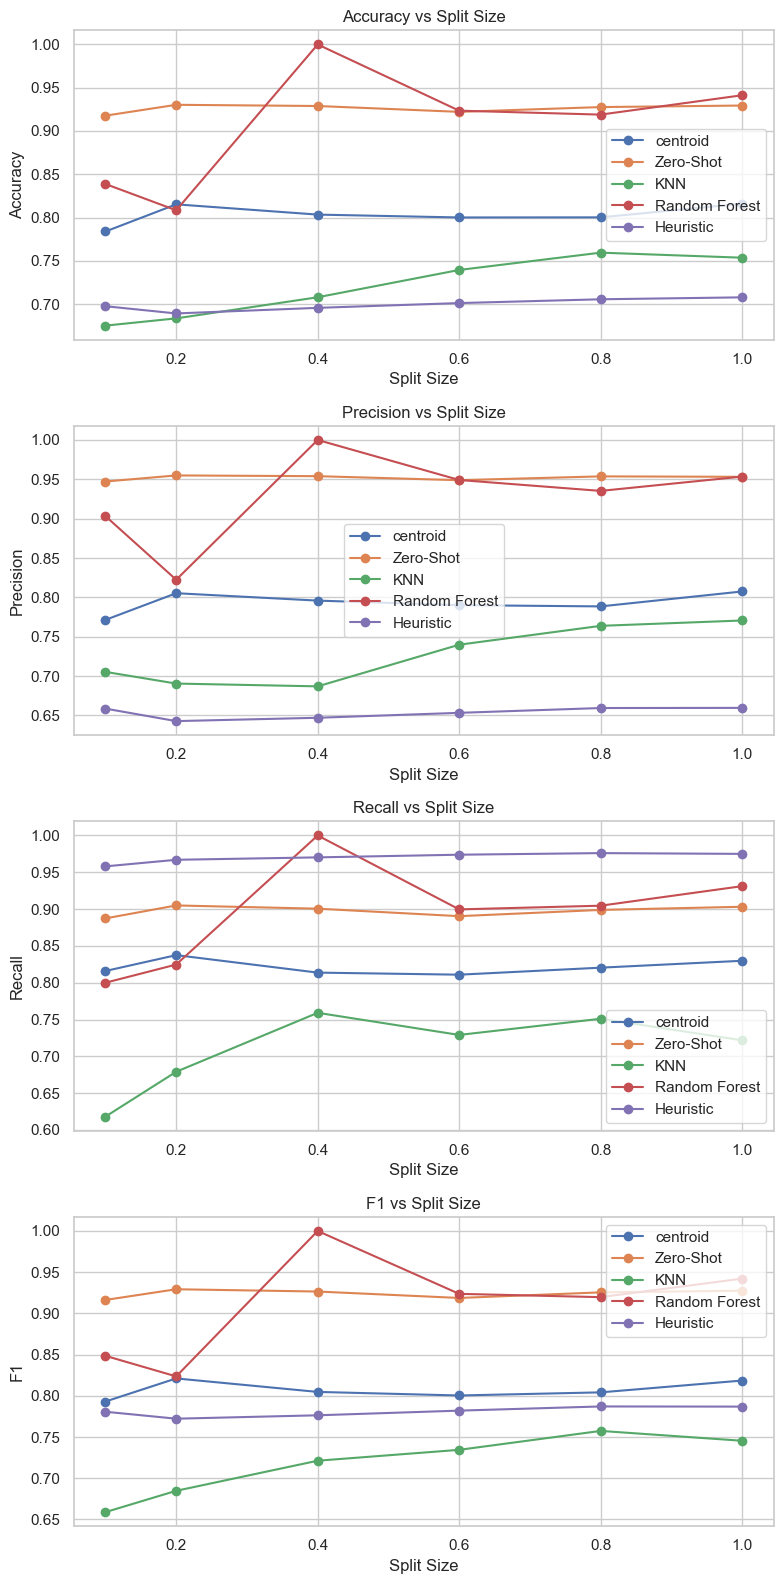

In [ ]:
evaluate_and_plot_weak_labels(labeled_splits_centroid, labeled_splits_zero_shot, labeled_splits_knn, labeled_splits_rf, labeled_splits_heuristic)

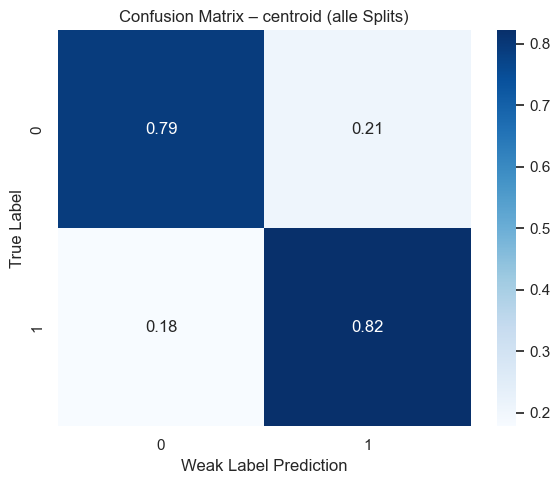

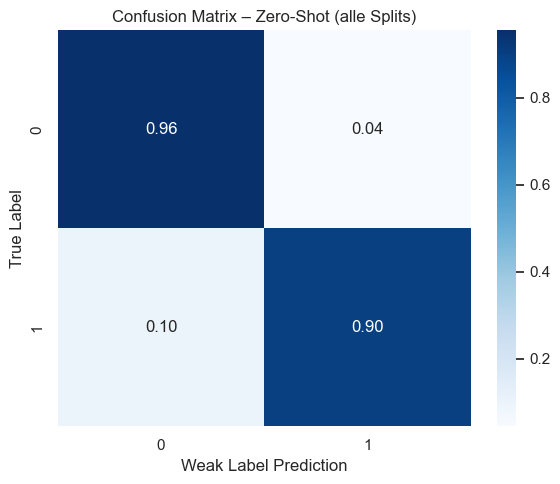

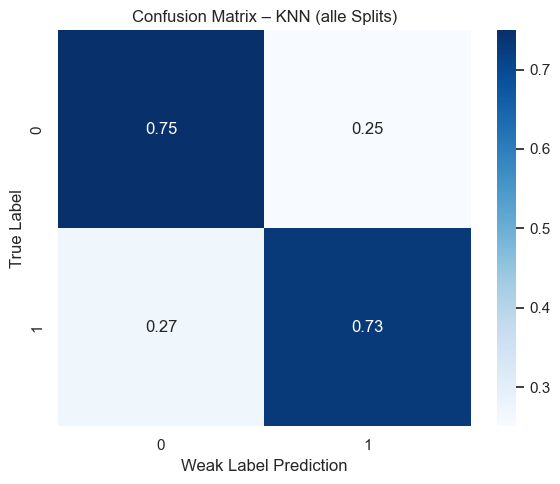

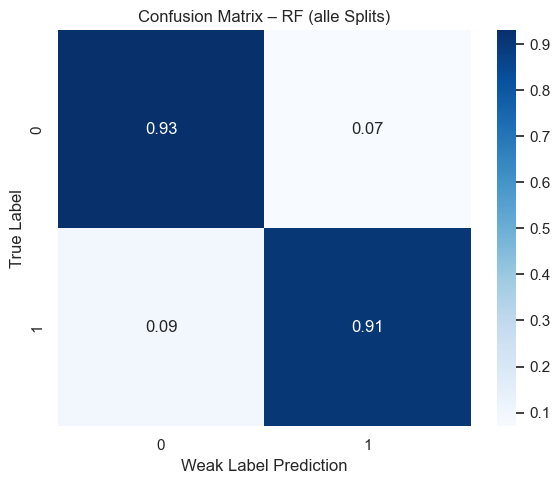

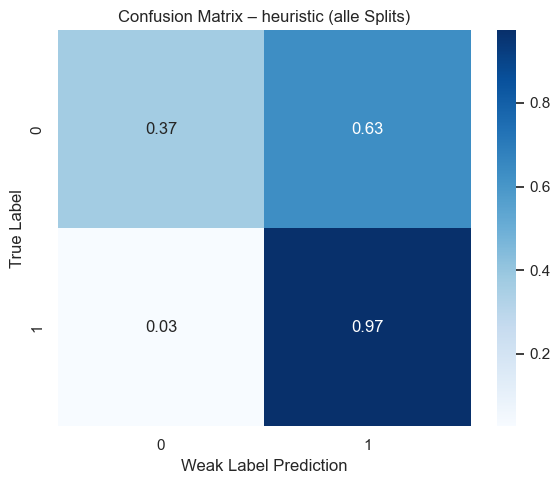

In [ ]:
plot_confusion_matrix_weak_labels(labeled_splits_centroid, method_name="centroid")

plot_confusion_matrix_weak_labels(labeled_splits_zero_shot, method_name="Zero-Shot")

plot_confusion_matrix_weak_labels(labeled_splits_knn, method_name="KNN")

plot_confusion_matrix_weak_labels(labeled_splits_rf, method_name="RF")

plot_confusion_matrix_weak_labels(labeled_splits_heuristic, method_name="heuristic")

**Analyse & Interpretation der Weak-Labeling-Methoden**
Die Auswertung zeigt deutliche Unterschiede in der Leistungsfähigkeit der verschiedenen Weak-Labeling-Ansätze – sowohl absolut als auch abhängig von der verfügbaren Menge an hart gelabelten Daten (split_size).

* **Zero-Shot Classification**
    * Stabilität & Qualität: Sehr hohe und konstante Werte in allen Metriken (Accuracy, Precision, Recall, F1), bereits ab kleinster Splitgröße.  
    * Erklärung: Diese Methode benötigt kein Training und nutzt ein stark vortrainiertes Modell, das direkt gut verallgemeinert.  
    * Fazit: Beste Wahl bei wenig oder gar keinen gelabelten Daten. Sehr robust gegen kleine Datenmengen.  

* **Random Forest mit Confidence-Threshold**
    * Performance: Teilweise überdurchschnittlich (zB. 100 % F1 bei Split 0.4), aber leichte Schwankungen.
    * Besonderheit: Adaptive Threshold-Wahl funktioniert besonders gut bei mittleren bis großen Splits, liefert dann sehr präzise Labels.
    * Fazit: Sehr geeignet bei mittlerem bis großem Labelbestand (ab Split 0.4), aber nicht optimal bei kleinen Splits.

* **Centroid-Matching**
    * Konstanz: Solide, aber leicht unter Zero-Shot und RF. Geringe Schwankungen bei steigender Split-Größe.
    * t-SNE-Bezug: Die zuvor gezeigte t-SNE-Visualisierung mit starker Überlappung zwischen Klassen erklärt die moderate Trennschärfe dieses Ansatzes. Da Klassen nicht sauber im Embedding-Raum separiert sind, stößt ein rein geometrischer Ansatz (wie Centroid Matching) an seine Grenzen.
    * Fazit: Einfach, effizient und solide – besonders geeignet, wenn schnelle, leicht skalierbare Methoden gefragt sind.

* **KNN auf Sentence Embeddings**
    * Trend: Leistung steigt klar mit Split-Größe – d.h. je mehr gelabelte Nachbarn zur Verfügung stehen, desto besser die Labels.
    * Problem: Schwach bei kleinen Splits, da die wenigen Nachbarn oft nicht repräsentativ sind (insbesondere bei überlappenden Embedding-Cluster).
    * Fazit: Gute Option ab mittlerer Datenmenge (Split >= 0.6); ungeeignet bei wenig harten Labels.

* **Heuristischer Ansatz**
    * Eigenheit: Sehr hoher Recall (fast 1.0), aber niedrige Precision -> viele false positives.
    * Grund: Regelbasierte LFs erkennen gezielt starke Sentiment-Phrasen, aber ignorieren Kontext/Ironie – was zu Überlabeling führt.
    * Fazit: Gut für Recall-orientierte Anwendungsfälle oder als Basis für Ensemble-Ansätze. Kein Ersatz für datengetriebene Methoden bei komplexeren Texten.

**Gesamtfazit**  
- Zero-Shot liefert die besten Ergebnisse über alle Splitgrößen hinweg und ist besonders in Low-Resource-Szenarien ideal.  
- Random Forest performt sehr gut, wenn genug Trainingsdaten vorliegen, bietet aber keine Vorteile bei sehr kleinen Splits.  
- Centroid ist effizient und überraschend stabil, sollte aber mit den t-SNE-überlappenden Clustern im Hinterkopf interpretiert werden.  
- KNN profitiert klar von mehr harten Labels, ist aber anfangs schwach – dies stimmt mit der lokalen Struktur der Embeddings aus der t-SNE-Analyse überein.  
- Heuristik ist zwar nachvollziehbar und einfach, aber in der Qualität begrenzt und eher ergänzend zu sehen.  

Die t-SNE-Visualisierungen vom vorherigen Abschnitt haben gezeigt, dass Klassen im semantischen Raum stark überlappen. Dies erklärt, warum kontextfreie Verfahren (wie Centroid oder KNN mit kleinem k) nicht optimal trennen können. Methoden, die stärker auf vortrainierte Sprachmodelle zurückgreifen (Zero-Shot, RF), liefern robustere Labels – gerade wenn weniger Ground Truth verfügbar ist.  


Nach dem Hinzufügen von Weak Labels kann es vorkommen, dass das resultierende **Klassenverhältnis unausgeglichen** ist – insbesondere wenn bestimmte Methoden systematisch eine Klasse bevorzugen. Sollte sich zeigen, dass die Verteilung der Klassen stark unausgeglichen ist, sollten geeignete Maßnahmen zur Balancierung in Betracht gezogen werden, um eine Verzerrung des Modells zu vermeiden.

Mögliche Strategien sind unter anderem das Downsampling der überrepräsentierten Klasse, wodurch ein gleichmäßiges Verhältnis der Klassen im Trainingsdatensatz erreicht werden kann. Alternativ kann ein klassengewichtetes Training eingesetzt werden, bei dem dem Modell höhere Fehlkosten für die unterrepräsentierte Klasse zugewiesen werden. Dadurch bleibt der gesamte Datensatz erhalten, während dennoch ein Ausgleich zwischen den Klassen geschaffen wird. Zusätzlich sollte bei der Aufteilung der Daten in Trainings- und Validierungssets auf eine stratifizierte Verteilung geachtet werden, um das Klassenverhältnis in allen Splits möglichst konstant zu halten.

Diese Maßnahmen sind insbesondere dann relevant, wenn die Qualität und Aussagekraft der Modellvorhersagen nicht durch eine verzerrte Klassenverteilung beeinträchtigt werden sollen.

# Modell-training mit Weak labels

### Erneutes Training mit Combination Hard & Weak labels in Trainingssplits  

**Modell-Training mit Weak Labels**

Nach der Generierung der Weak Labels in den vorbereiteten Trainingssplits wird ein erneutes Modelltraining durchgeführt. Dabei werden die ursprünglich manuell annotierten Datenpunkte (Hard Labels) mit den automatisch erzeugten Weak Labels kombiniert, um ein möglichst großes und umfassendes Trainingsset zu erhalten.

Dieses Vorgehen simuliert eine realistische Anwendungssituation, in der Unternehmen nur einen kleinen Teil ihrer Daten manuell beschriften, aber gleichzeitig von der Skalierbarkeit automatisierter Labeling-Verfahren profitieren möchten.


Für jedes hierarchisch aufgebaute Split (zB. 10 %, 20 %, 40 % der Daten) wurde ein Modell trainiert, das sowohl Hard als auch Weak Labels nutzt. Die Label-Kennzeichnung (`label_type`) wurde bewusst beibehalten, um später auch Label-Gewichtungen oder Fehleranalysen je nach Ursprung des Labels durchführen zu können.

**Wichtig dabei:** Für alle Trainingsläufe mit Weak Labels wurde **das gleiche Modell und Embedding-Verfahren** verwendet wie beim Baseline-Modelltraining.

In diesem Projekt: `distilbert-base-uncased` mit Mean Pooling der Token-Embeddings

---

**Warum dasselbe Modell wie in der Baseline?**

Um die Effektivität von Weak Labelling objektiv zu bewerten, ist es essenziell, dass das Modelltraining selbst **keinen zusätzlichen Bias einführt**. Würde man für das Weak Labelling ein anderes Modell oder eine andere Architektur verwenden als für die Baseline, wäre nicht mehr klar, ob ein Performance-Unterschied vom Labeling oder vom Modell stammt.

Durch die Verwendung desselben Modells bleiben alle anderen Einflussfaktoren konstant, und die Unterschiede in der Modellleistung können **klar auf die Labelqualität und -anzahl zurückgeführt werden**.

---

**Ziel dieser Evaluation**

Das Ziel ist es herauszufinden:
- Ob das zusätzliche Weak Labeling die Modellleistung verbessert
- Wie sich verschiedene Weak Label Methoden auf die finale Qualität auswirken
- Wie viel manuelle Annotation durch gute Weak Labels potenziell eingespart werden kann


#### Auswahlbegründung:  
##### Model:  
Für das Training mit den Weak Labels wurde ein **Feature-Extraction-Ansatz gewählt**. Auch wenn ein feinjustiertes (fine-getuntes) Modell erwartungsgemäß eine etwas höhere Modellleistung erzielt hätte, fiel die Entscheidung bewusst zugunsten der Feature-Extraction-Variante.  
Der Hauptgrund dafür war der zeitliche Aufwand: Fine-Tuning ist deutlich rechenintensiver und benötigt längere Trainingszeiten, insbesondere bei mehrfachen Experimentdurchläufen mit verschiedenen Splits und Weak-Label-Konfigurationen.  
Trotz des einfacheren Ansatzes zeigte das Feature-Extraction-Modell nur geringfügig schlechtere Ergebnisse, wodurch sich insgesamt ein günstigeres Verhältnis von Aufwand zu Performance ergibt – also ein effizientes Preis-Leistungs-Verhältnis im Kontext dieser Challenge.

##### Centroid und Zero-Shot zur Weak-Label-Generierung:

Wir haben uns für Zero-Shot und Centroid entschieden, da sie sich in der Evaluation als besonders zuverlässig und praktikabel erwiesen haben:  
Zero-Shot erzielte durchgehend beste Ergebnisse, funktioniert ohne Trainingsdaten und ist damit ideal für kleine Datensätze oder schnelle Anwendungen.  
Centroid bietet eine einfache, schnelle und transparente Lösung mit solider Performance, besonders bei großen Datenmengen oder für skalierbare Szenarien.  
Beide Methoden adressieren unterschiedliche Anforderungen und bieten jeweils klare Vorteile – je nach Datensituation und Zielsetzung.  

Zur Auswahl geeigneter Methoden zur automatisierten Generierung von Weak Labels wurden mehrere Verfahren miteinander verglichen. Die Entscheidung fiel auf **Centroid** und **Zero-Shot Klassifikation**, da diese zwei Verfahren sowohl **in den quantitativen Metriken** als auch **in der praktischen Anwendbarkeit** überzeugten.

---

##### Metrikverläufe über Split-Größen hinweg

Die Metrik-Plots (Accuracy, Precision, Recall, F1) über verschiedene Trainingssplit-Größen zeigen klare Stärken beider gewählter Methoden:

**Centroid**
- Zeigt stabile und solide Werte über alle Splitgrößen hinweg.
- Besonders Recall und F1-Score bewegen sich konstant über 80 %, was auf eine ausgewogene Klassifikation hinweist.
- Aufgrund der Einfachheit und guten Skalierbarkeit besonders nützlich für große Mengen unbeschrifteter Daten.

**Zero-Shot**
- Liefert bereits bei kleinen Split-Größen **sehr hohe Metriken** (Accuracy und F1 > 0.92).
- Zeigt **kaum Leistungsunterschiede über alle Splits hinweg** – ein Zeichen für **hohe Robustheit und Generalisierung** ohne zusätzliches Training.
- Perfekt geeignet zur **Initialisierung von Labels**, wenn kaum Trainingsdaten vorhanden sind.

---

##### Vergleich mit anderen Methoden

**Heuristik**
- Liefert stellenweise extrem hohe Metriken (z. B. 100 % Accuracy bei Split 0.4), allerdings **instabil und nicht reproduzierbar**.
- Teilweise **überoptimistisch (Overfitting)**, was bei echten Anwendungen problematisch ist.

**Random Forest**
- Zeigt **nur geringe Unterschiede über alle Splits hinweg**, was auf mangelnde Lernfähigkeit hindeutet.
- Insgesamt **niedrigere Precision und F1** im Vergleich zu KNN und Zero-Shot.

**KNN**
- In frühen Tests berücksichtigt, aber letztlich nicht ausgewählt, da Centroid effizienter ist und in der Praxis ähnliche oder bessere Ergebnisse liefert – insbesondere bei stark überlappenden Embedding-Clustern (siehe t-SNE-Analyse).

---

##### Gesamtfazit

Die Entscheidung für **Centroid und Zero-Shot** basiert auf folgenden Überlegungen:  

| Kriterium                       | Centroid                            | Zero-Shot                |
| ------------------------------- | ----------------------------------- | ------------------------ |
| **Leistung bei kleinen Splits** | Gut                                 | Sehr gut                 |
| **Leistungszuwachs mit Daten**  | Stabil, solide                      | Konstant hoch            |
| **Precision / F1**              | Hoch, ausgewogen                    | Sehr stark               |
| **Robustheit**                  | Unempfindlich gegenüber Overfitting | Sehr robust              |
| **Erklärbarkeit**               | Hoch (Cosine zu Klassenzentren)     | Mittel (Blackbox-Modell) |



In [5]:
weight_configs = {
    "weak_0.1": {"weight_orig": 1.0, "weight_weak": 0.1},
    "weak_0.5": {"weight_orig": 1.0, "weight_weak": 0.5},
    "weak_1.0": {"weight_orig": 1.0, "weight_weak": 1.0},
}
# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# split_data = split_nested_splits(nested_splits, test_size=0.2, val_size=0.1)

# results = {}
# for name, wc in weight_configs.items():
#     cent_res, zero_res = run_experiments_with_weights(
#         split_data, labeled_splits_centroid, labeled_splits_zero_shot,
#         model, wc['weight_orig'], wc['weight_weak']
#     )
#     results[name] = {'centroid': cent_res, 'zero': zero_res}

In [4]:
# pickle laden
with open("../MC2/data_weak_labels/weak_label_experiments.pkl", "rb") as f:
    results = pickle.load(f)

#### **Analyse: Einfluss unterschiedlicher Weak-Label-Gewichtungen auf die Modellqualität (siehe Plots unten)**

Die drei Plots zeigen, wie sich **Accuracy**, **F1-Score** und die **durchschnittliche Modellkonfidenz** in Abhängigkeit von der Split-Größe sowie der **Trainingsgewichtung der Weak Labels** entwickeln.

Die Bezeichnungen `methode_weak_0.1`, `weak_0.5` und `weak_1.0` stehen dabei **nicht für den Anteil an Weak Labels**, sondern geben an, **wie stark die Weak Labels im Modelltraining gewichtet wurden** (z. B. 0.1 = schwach gewichtet, 1.0 = gleichgewichtet wie harte Labels).


**Accuracy vs. Split Size**  
Allgemeiner Trend: Die Accuracy steigt bei beiden Methoden (Zero-Shot und Centroid) mit zunehmender Split-Größe – mit einem klaren Leistungsminimum bei Split 0.6.


**Vergleich der Methoden:**  
Zero-Shot erzielt insgesamt **etwas höhere Accuracy-Werte** als Centroid, vor allem im Bereich von Split 0.2 bis 0.4.  
Auffällig ist: Bei Split 0.4 erreicht **Zero_weak_0.1** sogar den höchsten Accuracy-Wert aller Konfigurationen.


**Einfluss der Weak-Label-Gewichtung – differenziert nach Methode:**  

- **Zero-Shot:**  
  Zwischen Split 0.2 und 0.6 zeigen sich deutliche Unterschiede in der Modellqualität je nach Gewichtung.  
  **Zero_weak_0.1** liegt spürbar unter den stärker gewichteten Varianten (0.5 und 1.0).  
  Erst ab Split 0.8 konvergieren die Linien wieder – das Modell wird robuster gegenüber der Gewichtung der Weak Labels.

- **Centroid:**  
  Bei Centroid sind die Unterschiede zwischen `weak_0.1`, `0.5` und `1.0` im Bereich von Split 0.2 bis 0.6 geringer.  
  Ab Split 0.8 zeigt sich ein klarer Vorteil für **Centroid_weak_1.0** – hier führt die stärkere Gewichtung der Weak Labels zu messbar besseren Ergebnissen.


**Interpretation:**  
Zero-Shot profitiert im mittleren Splitbereich deutlich von einer **höheren Gewichtung** der Weak Labels. Eine zu niedrige Gewichtung (z. B. 0.1) reicht dort offenbar nicht aus, um die volle Modellleistung zu entfalten.  
Centroid hingegen reagiert im mittleren Bereich weniger empfindlich auf die Gewichtung, zeigt aber bei größeren Splits (0.8–1.0) einen **klaren Leistungszuwachs bei voller Gewichtung** der Weak Labels.


**Fazit:**  
Die beiden Methoden verhalten sich unterschiedlich:

- **Zero-Shot ist bei kleinen bis mittleren Splits sensibler gegenüber der Weak-Label-Gewichtung**, wird aber bei großen Splits stabiler.
- **Centroid profitiert stärker bei großen Datenmengen von einer hohen Weak-Label-Gewichtung** und zeigt dort deutlich bessere Ergebnisse bei `weak_1.0`.


#### **Auffälligkeit bei Split Size 0.6 – Analyse eines temporären Leistungsabfalls**

Beim Vergleich der Modellmetriken über verschiedene Split-Größen hinweg zeigt sich ein auffälliger Peak bei Split 0.4, gefolgt von einem deutlichen Leistungsabfall bei Split 0.6 – sowohl bei **Accuracy** als auch beim **F1-Score**.  
Dieser Effekt tritt konsistent über alle getesteten Konfigurationen auf, unabhängig davon, ob die Weak Labels mit geringer (0.1), mittlerer (0.5) oder voller Gewichtung (1.0) in das Training eingebracht wurden.

**Mögliche Ursachen:**

- **Ungünstige Zusammensetzung der zusätzlich eingebrachten Daten:**  
  Die beim Übergang von Split 0.4 auf 0.6 hinzukommenden Texte könnten semantisch komplexer, mehrdeutig oder kontextabhängiger formuliert sein (z. B. Ironie, implizites Sentiment). Dadurch wird die Trennbarkeit im Modell erschwert.

- **Zunehmende Heterogenität bei gleichbleibender Weak-Label-Qualität:**  
  Besonders bei Centroid kann die Erweiterung des Datensatzes zu schlechteren Klassenzuordnungen führen, wenn neue Embeddings weniger klar einem Klassenzentrum zugeordnet werden können.  
  Auch Zero-Shot reagiert sensibel auf domänenspezifische oder mehrdeutige Sprache, wenn keine zusätzliche Kontextanpassung erfolgt.

- **Strukturelle Verzerrungen durch hierarchische Splits:**  
  Da die Splits hierarchisch aufgebaut sind, könnten in Split 0.6 neue semantische Cluster eingeführt worden sein, die im Embedding-Raum mit bestehenden Klassen überlappen (vgl. t-SNE-Analyse). Dies führt kurzfristig zu einer reduzierten Trennschärfe im Modell.

**Interpretation:**

Der beobachtete Leistungsabfall bei Split 0.6 ist **kein Hinweis auf eine grundsätzliche Schwäche der verwendeten Methoden**, sondern verdeutlicht, wie stark sich **inhaltliche Eigenschaften** der Daten sowie die **interne Struktur des Embedding-Raums** auf die Modellgüte auswirken können – unabhängig davon, wie die Weak Labels gewichtet wurden.

Ab Split 0.8 stabilisieren sich Accuracy und F1-Score wieder deutlich.  
Das Modell kann die gestiegene Komplexität durch die **zunehmende Datenmenge kompensieren**, wodurch die Entscheidungssicherheit und die Gesamtleistung wieder steigen.

#### **Analyse: Mean Confidence vs. Split Size**

Der Plot zur mittleren Konfidenz (Mean Confidence) zeigt, wie sicher sich das Modell bei seinen Vorhersagen fühlt – unabhängig davon, ob diese korrekt sind.

**Allgemeiner Trend:**
- Die durchschnittliche Konfidenz steigt kontinuierlich mit wachsender Split-Größe – sowohl bei **Centroid**- als auch bei **Zero-Shot**-basierten Weak-Label-Strategien.
- Dieser Trend ist plausibel: Mit mehr Trainingsdaten (Hard + Weak Labels) lernt das Modell stabilere Entscheidungsgrenzen und äußert sich entsprechend sicherer.

**Vergleich der Weak-Label-Gewichtungen:**
- Bei **Centroid** erreicht die Variante mit **voller Weak-Label-Gewichtung (`weak_1.0`)** die höchste mittlere Konfidenz. Das deutet darauf hin, dass das Modell die weak-gelabelten Daten bei dieser Einstellung als besonders einflussreich einbezieht.
- Die **Zero-Shot**-Varianten zeigen im Mittel etwas niedrigere, aber ebenfalls stetig wachsende Konfidenz. Auch hier steigt das Modellvertrauen mit zunehmender Split-Größe und stärkerer Weak-Label-Gewichtung.

**Auffälligkeit bei Split 0.6:**
- Obwohl die Konfidenz in Split 0.6 weiter ansteigt, sinken gleichzeitig Accuracy und F1-Score bei allen Methoden.
- Das deutet auf eine Form von **Überkonfidenz** hin: Das Modell ist sich seiner Vorhersagen sehr sicher, trifft aber relativ häufiger falsche Entscheidungen.
- Eine mögliche Ursache liegt in der Zusammensetzung der zusätzlich eingebrachten Daten in Split 0.6 – etwa semantisch komplexere, uneindeutige oder schwächer gelabelte Beispiele, die das Modell fehlleiten.

**Fazit:**
- **Mehr Daten und höhere Gewichtung der Weak Labels führen zu einem deutlich höheren Modellvertrauen.**
- Besonders bei Centroid wirkt sich `weak_1.0` stark auf die durchschnittliche Sicherheit des Modells aus.
- Allerdings gilt: **Hohe Konfidenz bedeutet nicht automatisch hohe Modellgüte** – wie der deutliche Qualitätsabfall bei Split 0.6 eindrücklich zeigt.


✔︎ Tabelle aller Splits gespeichert: ../MC2/results/my_weighted_reports/metrics_table_weighted.csv


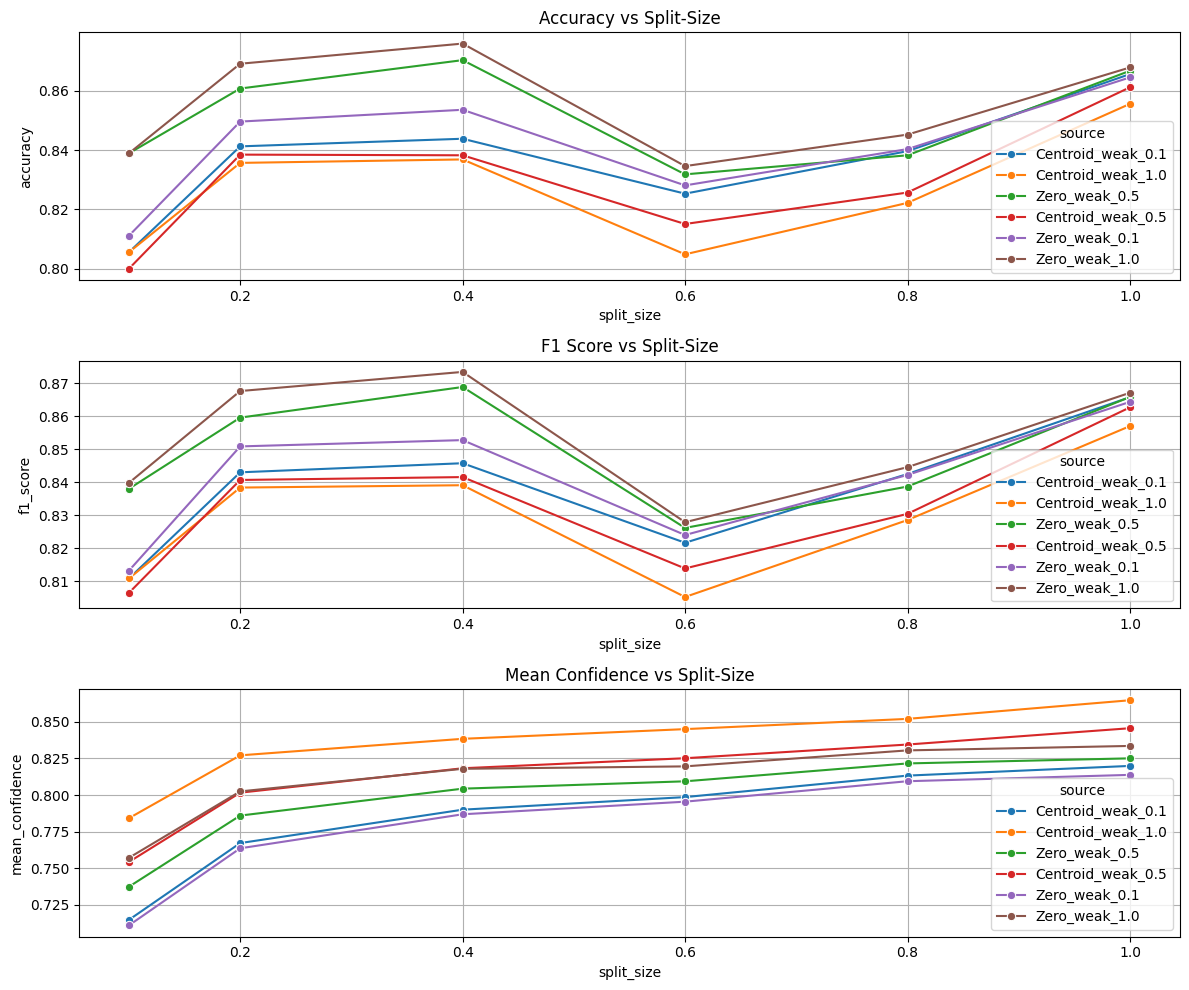

<Figure size 640x480 with 0 Axes>

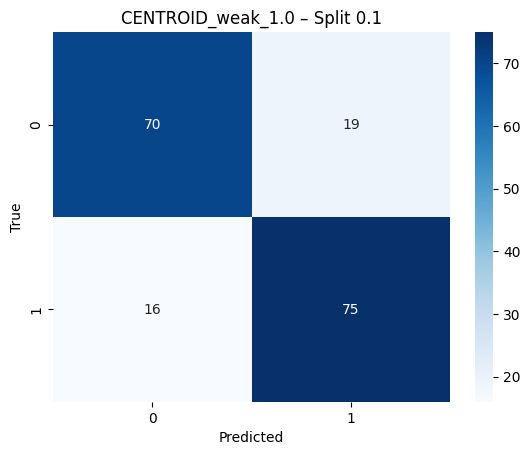

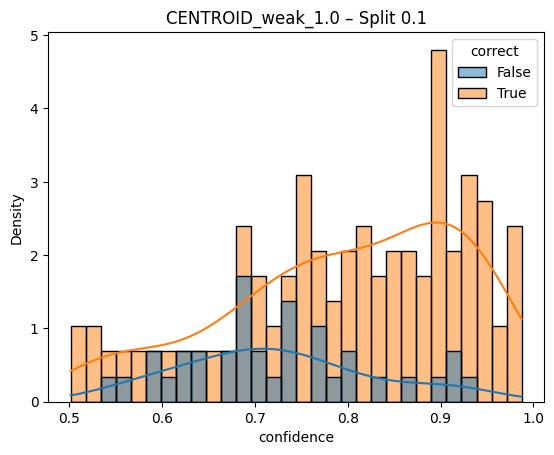

===== CENTROID_weak_1.0 – Split 0.1 =====
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        89
           1       0.80      0.82      0.81        91

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180

------------------------------------------------------------


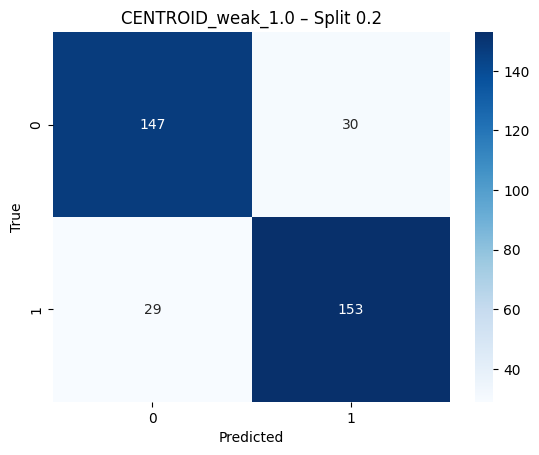

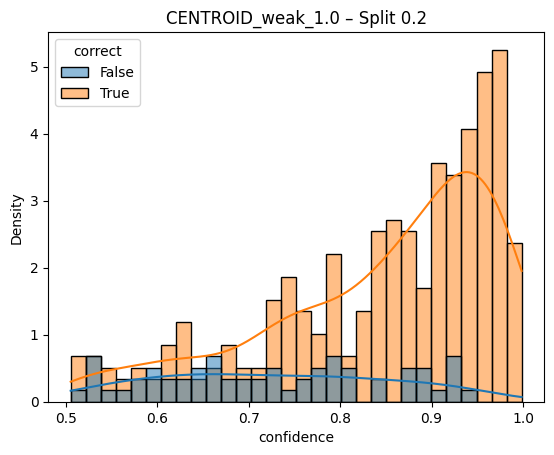

===== CENTROID_weak_1.0 – Split 0.2 =====
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       177
           1       0.84      0.84      0.84       182

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359

------------------------------------------------------------


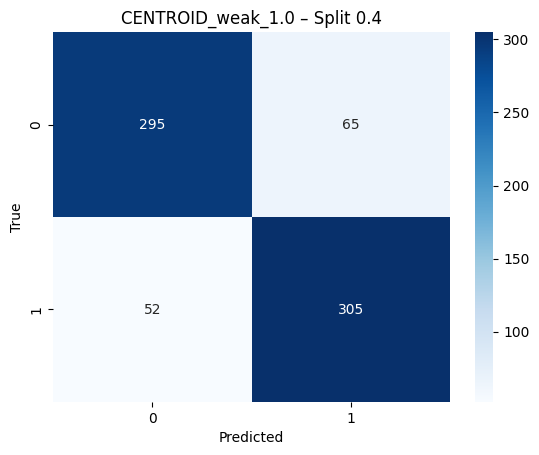

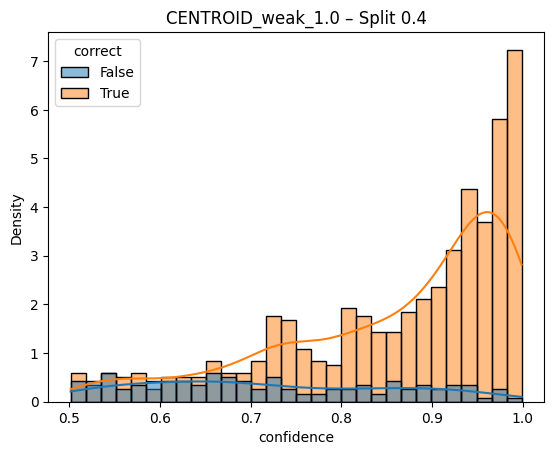

===== CENTROID_weak_1.0 – Split 0.4 =====
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       360
           1       0.82      0.85      0.84       357

    accuracy                           0.84       717
   macro avg       0.84      0.84      0.84       717
weighted avg       0.84      0.84      0.84       717

------------------------------------------------------------


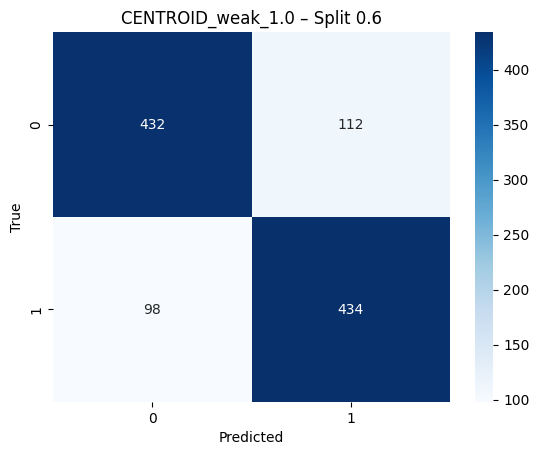

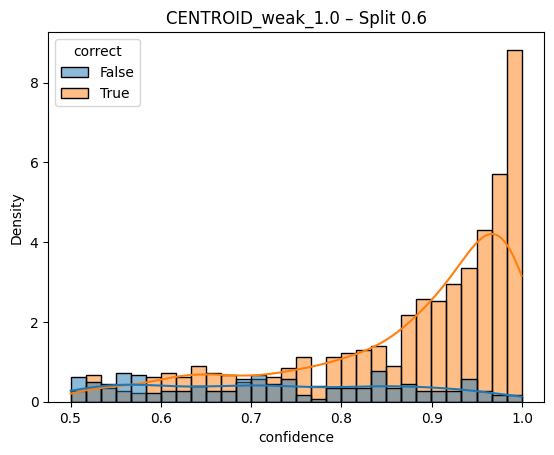

===== CENTROID_weak_1.0 – Split 0.6 =====
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       544
           1       0.79      0.82      0.81       532

    accuracy                           0.80      1076
   macro avg       0.80      0.80      0.80      1076
weighted avg       0.81      0.80      0.80      1076

------------------------------------------------------------


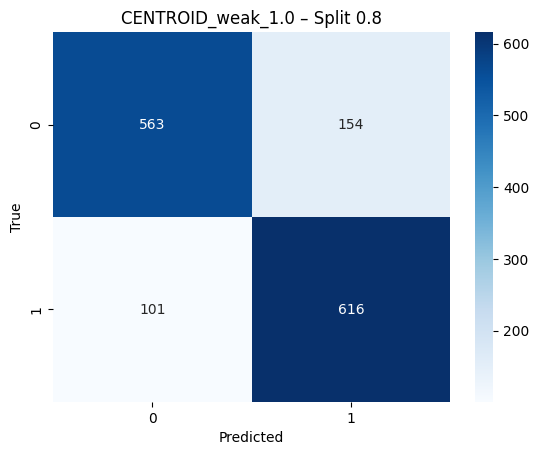

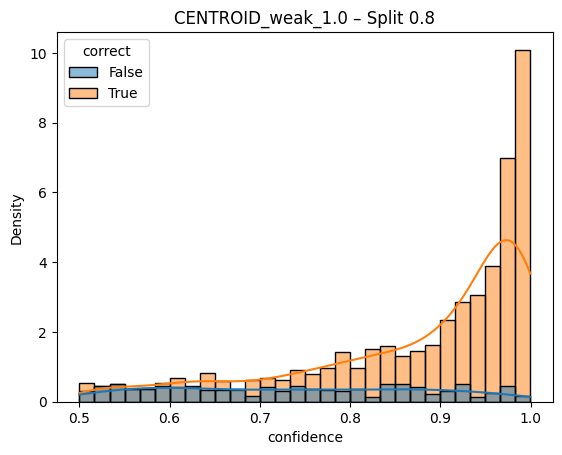

===== CENTROID_weak_1.0 – Split 0.8 =====
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       717
           1       0.80      0.86      0.83       717

    accuracy                           0.82      1434
   macro avg       0.82      0.82      0.82      1434
weighted avg       0.82      0.82      0.82      1434

------------------------------------------------------------


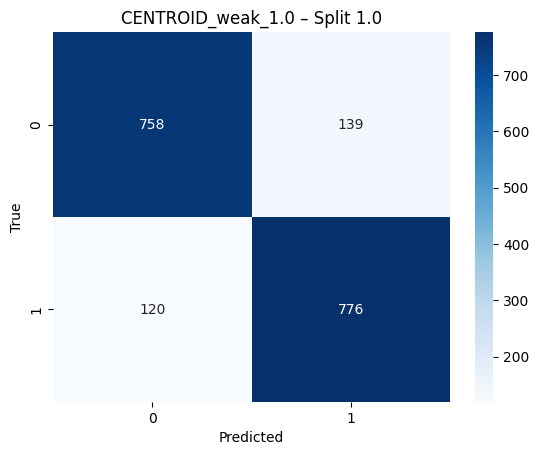

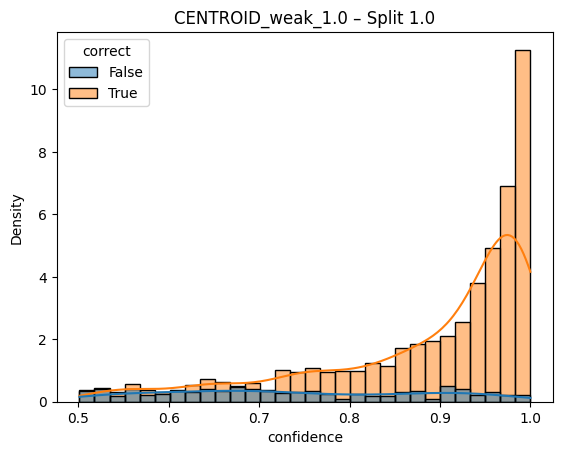

===== CENTROID_weak_1.0 – Split 1.0 =====
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       897
           1       0.85      0.87      0.86       896

    accuracy                           0.86      1793
   macro avg       0.86      0.86      0.86      1793
weighted avg       0.86      0.86      0.86      1793

------------------------------------------------------------


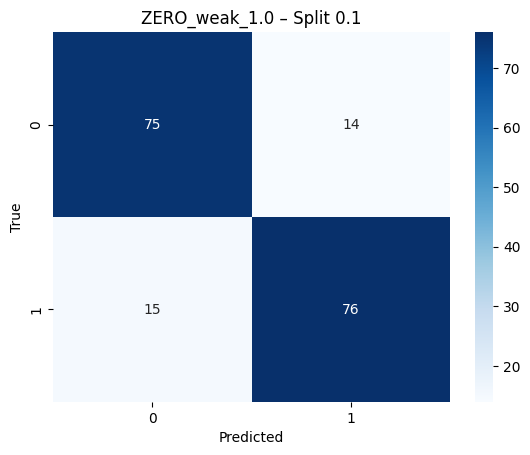

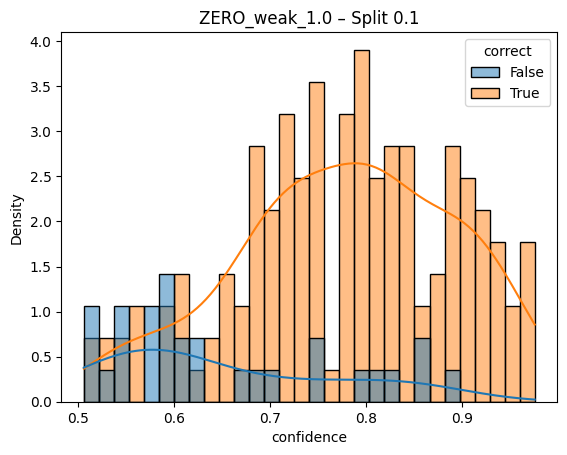

===== ZERO_weak_1.0 – Split 0.1 =====
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        89
           1       0.84      0.84      0.84        91

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180

------------------------------------------------------------


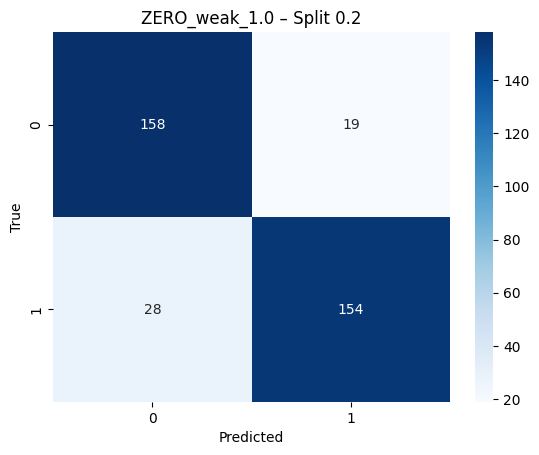

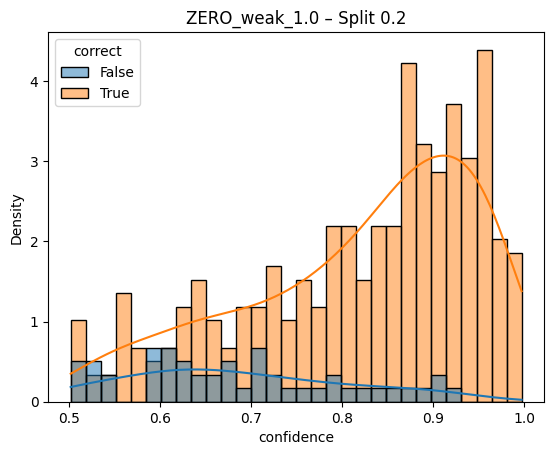

===== ZERO_weak_1.0 – Split 0.2 =====
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       177
           1       0.89      0.85      0.87       182

    accuracy                           0.87       359
   macro avg       0.87      0.87      0.87       359
weighted avg       0.87      0.87      0.87       359

------------------------------------------------------------


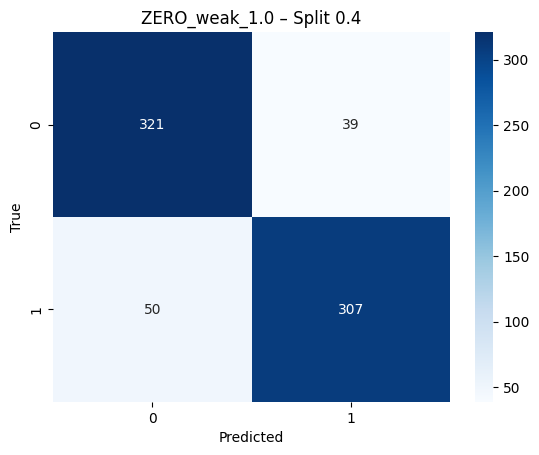

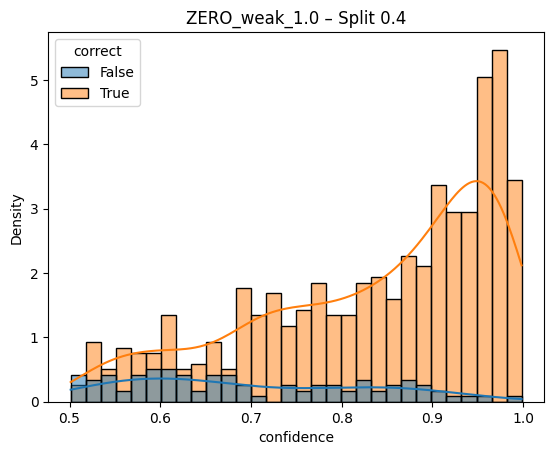

===== ZERO_weak_1.0 – Split 0.4 =====
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       360
           1       0.89      0.86      0.87       357

    accuracy                           0.88       717
   macro avg       0.88      0.88      0.88       717
weighted avg       0.88      0.88      0.88       717

------------------------------------------------------------


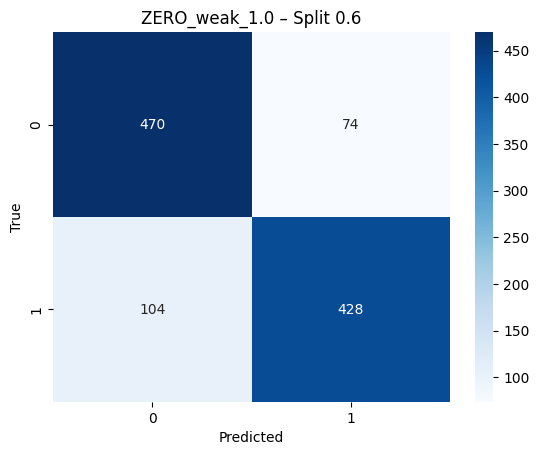

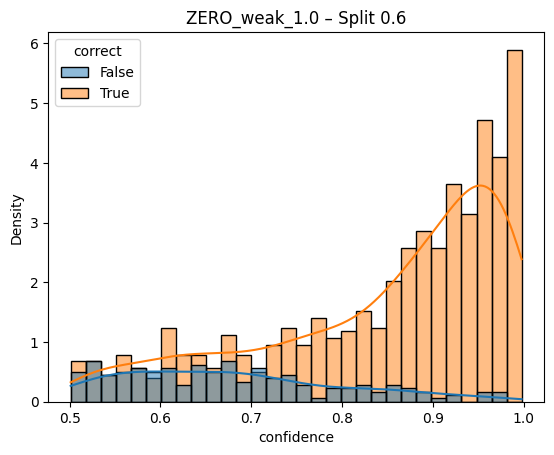

===== ZERO_weak_1.0 – Split 0.6 =====
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       544
           1       0.85      0.80      0.83       532

    accuracy                           0.83      1076
   macro avg       0.84      0.83      0.83      1076
weighted avg       0.84      0.83      0.83      1076

------------------------------------------------------------


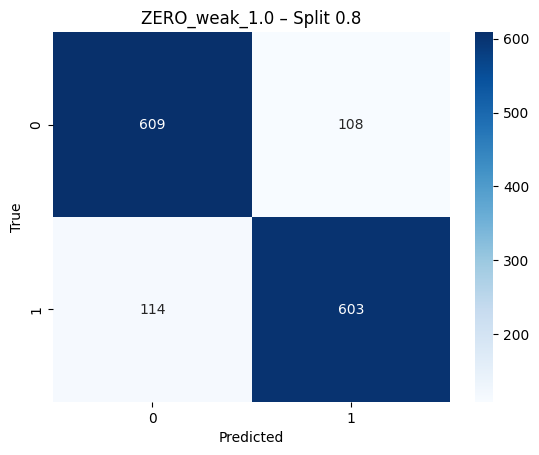

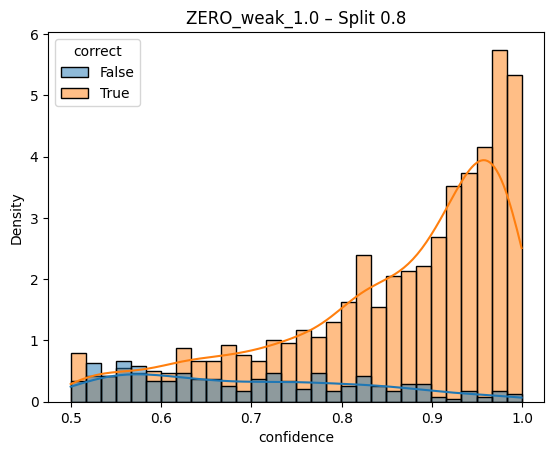

===== ZERO_weak_1.0 – Split 0.8 =====
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       717
           1       0.85      0.84      0.84       717

    accuracy                           0.85      1434
   macro avg       0.85      0.85      0.85      1434
weighted avg       0.85      0.85      0.85      1434

------------------------------------------------------------


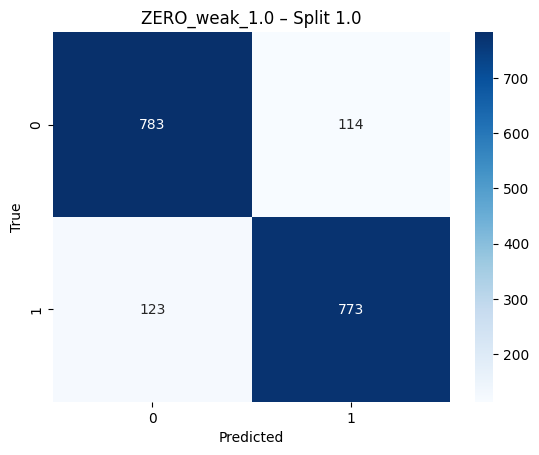

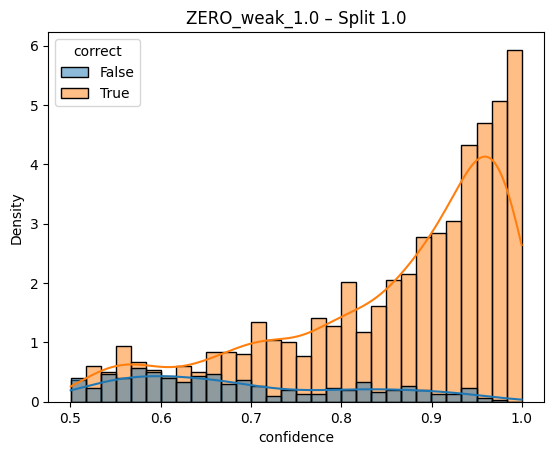

===== ZERO_weak_1.0 – Split 1.0 =====
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       897
           1       0.87      0.86      0.87       896

    accuracy                           0.87      1793
   macro avg       0.87      0.87      0.87      1793
weighted avg       0.87      0.87      0.87      1793

------------------------------------------------------------
Alle Plots & Tabellen liegen in: /Users/husazwerg/code/gitlab.fhnw.ch/gruppen_arbeit/npr_fs25/MC2/results/my_weighted_reports


In [9]:
full_report_weighted(results, weight_configs, out_dir="../MC2/results/my_weighted_reports", show=True)

### Evaluierung (Weak & Hard Label) vs Baseline Leistung  (beides Feature-extraction-Ansatz)  







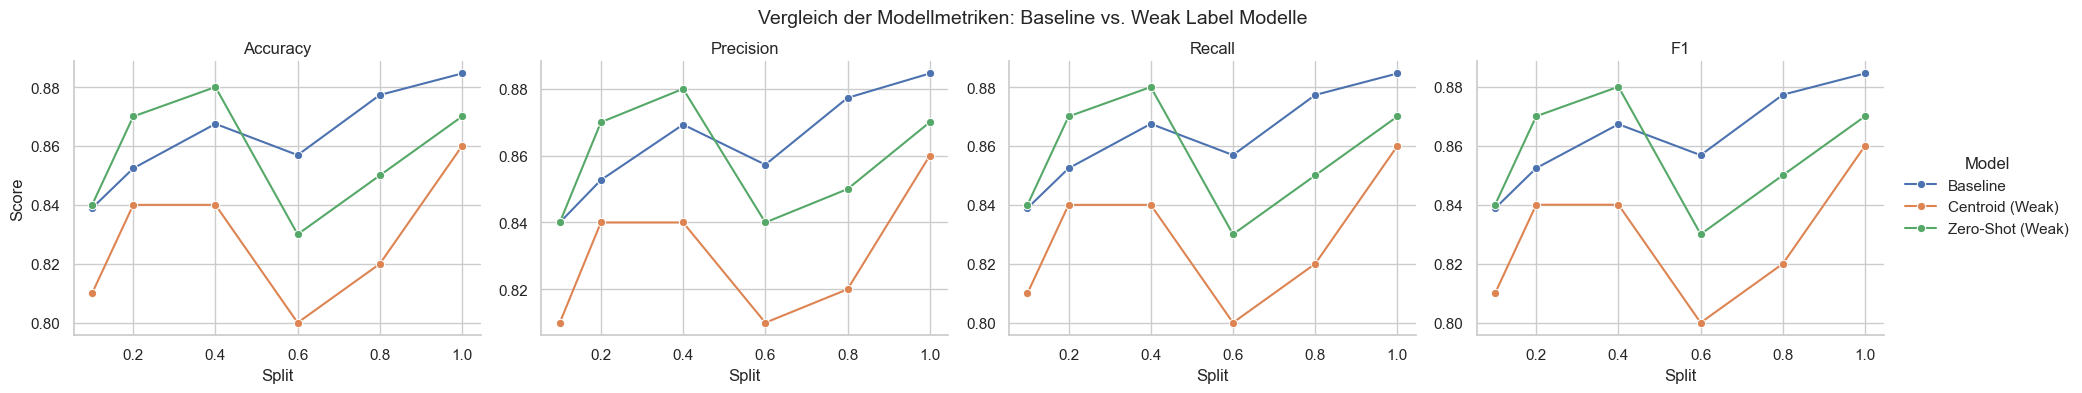

In [10]:
# Split
splits = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

# Baseline (Feature Extraction nur Hard Labels)
baseline = {
    'Accuracy':  [0.8389, 0.8524, 0.8675, 0.8569, 0.8773, 0.8846],
    'Precision': [0.8400, 0.8527, 0.8693, 0.8573, 0.8773, 0.8846],
    'Recall':    [0.8389, 0.8524, 0.8675, 0.8569, 0.8773, 0.8846],
    'F1':        [0.8388, 0.8524, 0.8673, 0.8568, 0.8773, 0.8845]
}

# Centroid weak_1.0
centroid = {
    'Accuracy':  [0.81, 0.84, 0.84, 0.80, 0.82, 0.86],
    'Precision': [0.81, 0.84, 0.84, 0.81, 0.82, 0.86],
    'Recall':    [0.81, 0.84, 0.84, 0.80, 0.82, 0.86],
    'F1':        [0.81, 0.84, 0.84, 0.80, 0.82, 0.86]
}


# Zero-Shot weak_1.0
zeroshot = {
    'Accuracy':  [0.84, 0.87, 0.88, 0.83, 0.85, 0.87],
    'Precision': [0.84, 0.87, 0.88, 0.84, 0.85, 0.87],
    'Recall':    [0.84, 0.87, 0.88, 0.83, 0.85, 0.87],
    'F1':        [0.84, 0.87, 0.88, 0.83, 0.85, 0.87]
}


# Umwandeln in long DF für Seaborn
rows = []
for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    for i, split in enumerate(splits):
        rows.append({'Split': split, 'Score': baseline[metric][i], 'Model': 'Baseline', 'Metric': metric})
        rows.append({'Split': split, 'Score': centroid[metric][i], 'Model': 'Centroid (Weak)', 'Metric': metric})
        rows.append({'Split': split, 'Score': zeroshot[metric][i], 'Model': 'Zero-Shot (Weak)', 'Metric': metric})

df_long = pd.DataFrame(rows)

sns.set(style='whitegrid')
g = sns.FacetGrid(df_long, col="Metric", hue="Model", height=4, aspect=1.2, sharey=False)
g.map(sns.lineplot, "Split", "Score", marker="o")
g.add_legend()
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Vergleich der Modellmetriken: Baseline vs. Weak Label Modelle", fontsize=14)
plt.show()


### Vergleich: Feature Extraction mit Hard Labels vs. mit vollständig gewichteten Weak Labels (`weak_1.0`)

Zur Bewertung des Effekts von Weak Labeling wurde die Leistung des Feature-Extraction-Modells **ohne zusätzliche Labels** (Baseline) mit den Ergebnissen **mit ergänzenden Weak Labels** (Centroid bzw. Zero-Shot) verglichen.  
In dieser Analyse wurden die Weak Labels **voll gewichtet ins Training integriert** (`weak_1.0`), d. h. sie haben denselben Einfluss auf das Modell wie die manuell annotierten Hard Labels.

Die Abbildung zeigt den Verlauf der vier zentralen Metriken (Accuracy, Precision, Recall, F1) über verschiedene Split-Größen hinweg.  
Deutlich sichtbar ist: Die Baseline mit ausschließlich manuell annotierten Daten erreicht erwartungsgemäß die besten Werte. Dennoch erzielen auch die **voll gewichteten Weak-Label-Modelle** beeindruckende Resultate – teils **nahe an der Baseline**.

#### Baseline (nur Hard Labels):
Die Baseline zeigt eine stetige Leistungssteigerung mit zunehmender Datenmenge. Zum Beispiel:
- Split 0.4: **F1-Score = 0.87**
- Split 1.0: **F1-Score = 0.88**

#### Feature Extraction mit Centroid (`weak_1.0`):
Das Modell mit Centroid-Labels (voll gewichtet) erreicht bei größeren Splits starke Ergebnisse:
- Split 0.4: **F1-Score = 0.84**
- Split 1.0: **F1-Score = 0.86**

→ Bereits mit vollständig gewichteten, automatisch erzeugten Labels lässt sich eine Performance erreichen, die nur **ca. 2–3 % unter der Baseline** liegt.

#### Feature Extraction mit Zero-Shot (`weak_1.0`):
Auch das Zero-Shot-Modell mit vollen Weak-Label-Gewichten liefert **durchgehend robuste Ergebnisse**:
- Split 0.4: **F1-Score = 0.88**
- Split 1.0: **F1-Score = 0.87**

→ Zero-Shot zeigt bei mehreren Splits **vergleichbare oder sogar leicht bessere Werte** als Centroid und bleibt insgesamt stabil.

#### Beobachtung bei vollständiger Weak-Label-Gewichtung (`weak_1.0`):
Die Modelle mit **100 % Gewichtung der Weak Labels** erzielen durchweg **hohe Scores** und bestätigen damit die Aussage:  
→ **Wenn die Qualität der Weak Labels ausreichend hoch ist, kann ihr Beitrag dem von Hard Labels ebenbürtig sein** – besonders bei größeren Trainingsmengen.

---

### Interpretation:

Die Ergebnisse zeigen, dass **voll gewichtet eingesetzte Weak Labels (`weak_1.0`) das Modelltraining effektiv unterstützen**, insbesondere bei größeren Splits.  
Mit ausreichend Daten und qualitativ sinnvollen automatisierten Labels ist es möglich, ein Modell zu trainieren, das **nahe an das Leistungsniveau vollständig manuell annotierter Modelle herankommt**.

**Vorteile im Überblick:**
- **Weniger manuelle Annotation notwendig**, bei vergleichbarer Performance
- **Zero-Shot benötigt kein eigenes Training**, liefert dennoch starke Resultate
- **Centroid-Ansatz ist effizient und skalierbar**, besonders bei großen Datenmengen
- **Volle Weak-Label-Gewichtung ist leistungsfähig**, wenn Labels hochwertig sind
- **Feature Extraction bleibt schnell und effektiv**, auch mit gemischten Label-Quellen


## Fazit

Sowohl mit **niedriger als auch mit voller Gewichtung** automatisch erzeugter Weak Labels lässt sich ein **Modell auf nahezu Baseline-Niveau trainieren** – bei deutlich geringerem manuellen Aufwand.  
Der Plot verdeutlicht: **Effizientes und skalierbares Weak Labeling ist realistisch umsetzbar – sowohl in vorsichtiger als auch in vollwertiger Einbindung.**

**Durch Weak Labeling konnten je nach Split-Größe bis zu 7169 von 8961 Labels automatisch generiert werden – eine Einsparung von 80 % manueller Annotation.**  
Gleichzeitig konnte die Modellleistung nahezu auf dem Niveau der voll gelabelten Variante gehalten werden.  
Das zeigt: **Effizientes semi-supervised Learning ist möglich – ohne signifikante Qualitätseinbußen.**

---

### Empfehlung zur Methodenauswahl

Die beiden getesteten Weak-Labeling-Ansätze – **Zero-Shot Classification** und **Centroid Matching** – zeigen unterschiedliche Stärken, die je nach Anwendungsfall sinnvoll genutzt werden können:

- **Zero-Shot Classification**
  - **Vorteile:** Kein Training nötig, direkt einsetzbar, konsistente Leistung bereits bei kleinen Datenmengen
  - **Empfehlung:** Ideal für Szenarien mit **wenig oder gar keinen harten Labels**, z. B. in frühen Projektphasen oder bei knappen Ressourcen
  - **Einsatzbereich:** Initiale Labelgenerierung, schnelle Prototypen, domänenferne Aufgaben

- **Centroid Matching**
  - **Vorteile:** Sehr effizient, leicht skalierbar, besonders stabil bei zunehmender Datenmenge
  - **Empfehlung:** Gut geeignet für **große, halbannotierte Datensätze**, in denen bereits eine gewisse Basis an harten Labels vorhanden ist
  - **Einsatzbereich:** Produktionsnahe Klassifikationsaufgaben, Datenexpansion in bestehenden Systemen

---

### Gesamtausblick

Die Ergebnisse unterstreichen das Potenzial von Weak Labeling als **kosteneffiziente und praxistaugliche Alternative zur vollständigen manuellen Annotation**.  
Gerade in Kombination mit ressourcenschonenden Modellarchitekturen wie **Feature Extraction** lassen sich **leistungsfähige Klassifikatoren** trainieren – selbst unter eingeschränkten annotativen Bedingungen.

**Empfehlung:**  
Für reale Szenarien mit begrenzten Ressourcen bietet sich ein **kombinierter Ansatz an**:  
- Zero-Shot zur schnellen Initialisierung,  
- Centroid zur strukturierten Labelverteilung,  
- kombiniert mit Feature Extraction zur stabilen Modellierung.

Damit lässt sich ein überzeugendes **Preis-Leistungs-Verhältnis** erreichen – ohne spürbare Qualitätseinbußen.
